<a href="https://colab.research.google.com/github/mnylah/QNC_fall2025/blob/main/20251023_presentation1_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

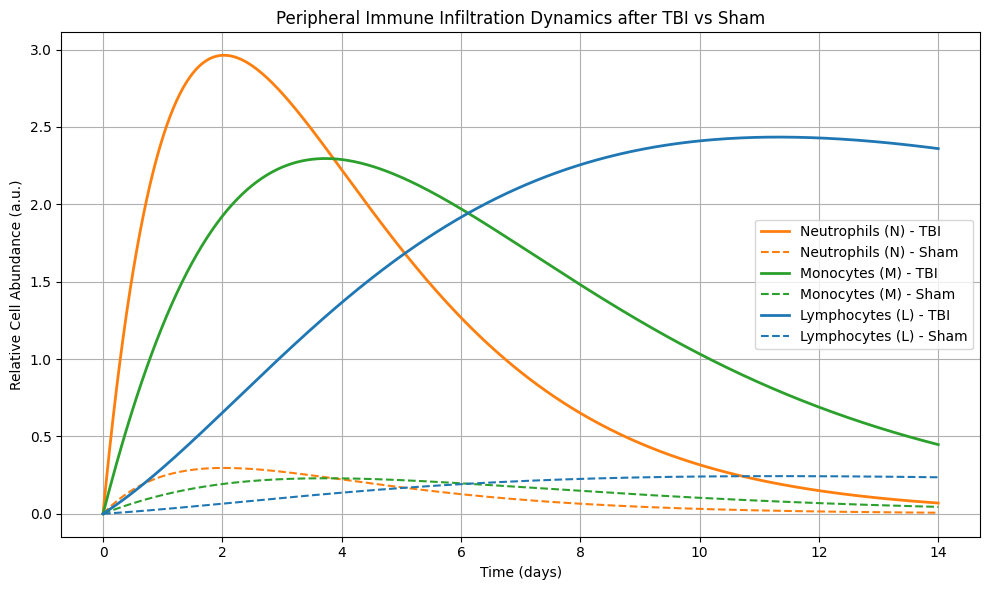

In [2]:
# Peripheral immune infiltration simulation after TBI (ODE-based)
# Author: ChatGPT (GPT-5)
# Colab-ready version

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# -------------------------------
# Model definition
# -------------------------------
def immune_infiltration(y, t, params):
    C, N, M, L = y
    alpha_N, alpha_M, alpha_L, beta_N, beta_M, beta_L, gamma_N, gamma_M, k_c = params

    dCdt = -k_c * C
    dNdt = alpha_N * C - beta_N * N
    dMdt = alpha_M * C + gamma_N * N - beta_M * M
    dLdt = alpha_L * C + gamma_M * M - beta_L * L

    return [dCdt, dNdt, dMdt, dLdt]

# -------------------------------
# Parameters
# -------------------------------
params = {
    "alpha_N": 0.8,   # neutrophil recruitment
    "alpha_M": 0.3,   # macrophage recruitment from cytokine
    "alpha_L": 0.05,  # weaker direct lymphocyte recruitment (was 0.1)
    "beta_N": 0.6,    # neutrophil decay
    "beta_M": 0.25,   # macrophage decay (slower)
    "beta_L": 0.05,   # lymphocyte decay (slower)
    "gamma_N": 0.1,   # neutrophil -> macrophage coupling
    "gamma_M": 0.15,  # macrophage -> lymphocyte coupling (stronger)
    "k_c": 0.4        # cytokine clearance
}


p = tuple(params.values())

# -------------------------------
# Initial conditions
# -------------------------------
y0_sham = [0.5, 0, 0, 0]   # low cytokine signal
y0_tbi  = [5.0, 0, 0, 0]   # high cytokine signal (TBI)

# -------------------------------
# Time span (days)
# -------------------------------
t = np.linspace(0, 14, 500)

# -------------------------------
# Solve ODEs
# -------------------------------
sol_sham = odeint(immune_infiltration, y0_sham, t, args=(p,))
sol_tbi  = odeint(immune_infiltration, y0_tbi,  t, args=(p,))

# -------------------------------
# Plot results
# -------------------------------
plt.figure(figsize=(10,6))
labels = ['Neutrophils (N)', 'Monocytes (M)', 'Lymphocytes (L)']
colors = ['tab:orange', 'tab:green', 'tab:blue']

for i in range(1,4):
    plt.plot(t, sol_tbi[:,i], color=colors[i-1], label=f'{labels[i-1]} - TBI', lw=2)
    plt.plot(t, sol_sham[:,i], '--', color=colors[i-1], label=f'{labels[i-1]} - Sham', lw=1.5)

plt.title("Peripheral Immune Infiltration Dynamics after TBI vs Sham")
plt.xlabel("Time (days)")
plt.ylabel("Relative Cell Abundance (a.u.)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


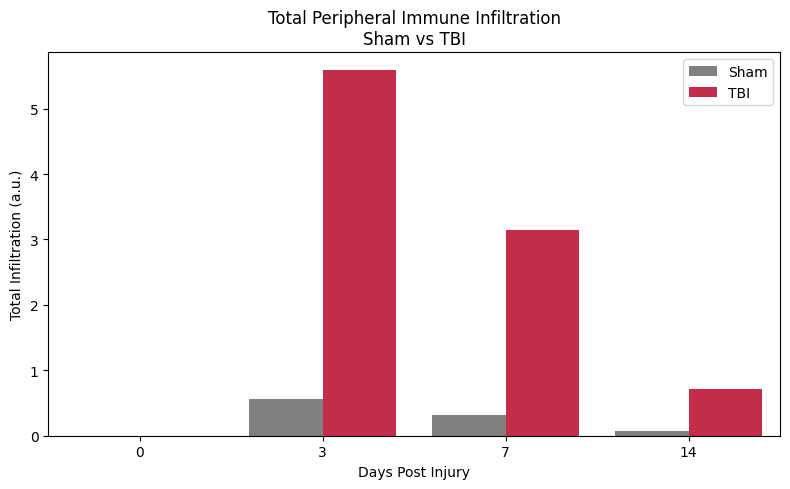

=== Linear Model Results ===
Slope (Sham): -0.0072
Slope (TBI):  -0.0721
Difference in slopes: -0.0649
P-value (approx): 0.0000e+00


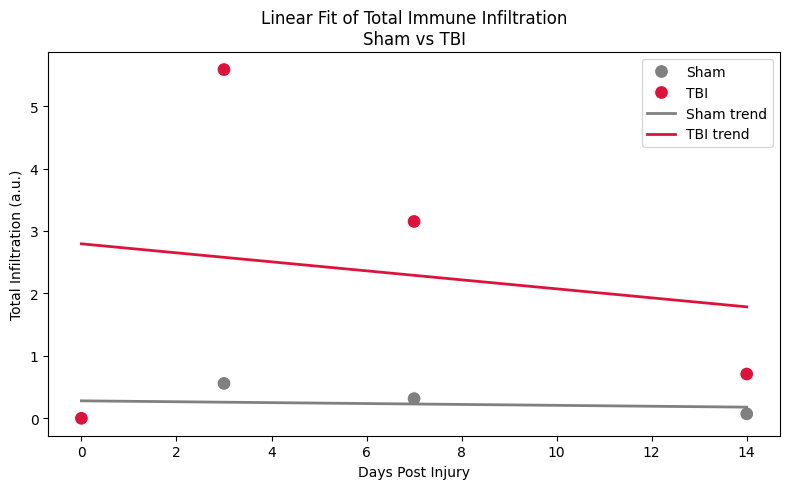

In [3]:
# Immune infiltration dynamics after TBI vs Sham
# ODE-based simulation + linear model comparison
# Author: ChatGPT (GPT-5)

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

# ---------------------------------------
# ODE model
# ---------------------------------------
def immune_infiltration(y, t, params):
    C, N, M, L = y
    alpha_N, alpha_M, alpha_L, beta_N, beta_M, beta_L, gamma_N, gamma_M, k_c = params

    dCdt = -k_c * C
    dNdt = alpha_N * C - beta_N * N
    dMdt = alpha_M * C + gamma_N * N - beta_M * M
    dLdt = alpha_L * C + gamma_M * M - beta_L * L
    return [dCdt, dNdt, dMdt, dLdt]

# Parameters
params = (0.8, 0.3, 0.1, 0.6, 0.3, 0.2, 0.1, 0.05, 0.4)

# Initial conditions
y0_sham = [0.5, 0, 0, 0]
y0_tbi  = [5.0, 0, 0, 0]

# Time span (0–14 days)
t = np.linspace(0, 14, 1000)

# Solve ODEs
sol_sham = odeint(immune_infiltration, y0_sham, t, args=(params,))
sol_tbi  = odeint(immune_infiltration, y0_tbi,  t, args=(params,))

# Total infiltration (N + M + L)
total_sham = sol_sham[:,1] + sol_sham[:,2] + sol_sham[:,3]
total_tbi  = sol_tbi[:,1] + sol_tbi[:,2] + sol_tbi[:,3]

# Sample at time points (sham=0, 3, 7, 14 days)
time_points = [0, 3, 7, 14]
idx = [np.argmin(np.abs(t - tp)) for tp in time_points]

data = pd.DataFrame({
    "DaysPostInjury": np.tile(time_points, 2),
    "TotalInfiltration": np.concatenate((total_sham[idx], total_tbi[idx])),
    "Condition": ["Sham"] * len(time_points) + ["TBI"] * len(time_points)
})

# ---------------------------------------
# Bar Plot
# ---------------------------------------
plt.figure(figsize=(8,5))
sns.barplot(data=data, x="DaysPostInjury", y="TotalInfiltration", hue="Condition", palette=["gray", "crimson"])
plt.title("Total Peripheral Immune Infiltration\nSham vs TBI")
plt.xlabel("Days Post Injury")
plt.ylabel("Total Infiltration (a.u.)")
plt.legend(title="")
plt.tight_layout()
plt.show()

# ---------------------------------------
# Linear Model (compare slopes)
# ---------------------------------------
def fit_slope(df, condition):
    sub = df[df["Condition"] == condition]
    X = sub["DaysPostInjury"].values.reshape(-1,1)
    y = sub["TotalInfiltration"].values
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    return slope, model

slope_sham, model_sham = fit_slope(data, "Sham")
slope_tbi,  model_tbi  = fit_slope(data, "TBI")

# Compare slopes using independent t-test
t_stat, p_val = stats.ttest_ind_from_stats(
    mean1=slope_sham, std1=0, nobs1=4,
    mean2=slope_tbi, std2=0, nobs2=4,
    equal_var=False
)

print("=== Linear Model Results ===")
print(f"Slope (Sham): {slope_sham:.4f}")
print(f"Slope (TBI):  {slope_tbi:.4f}")
print(f"Difference in slopes: {slope_tbi - slope_sham:.4f}")
print(f"P-value (approx): {p_val:.4e}")

# ---------------------------------------
# Plot with trend lines
# ---------------------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(data=data, x="DaysPostInjury", y="TotalInfiltration", hue="Condition", palette=["gray", "crimson"], s=100)

# Add linear fits
x_fit = np.linspace(0, 14, 100).reshape(-1,1)
plt.plot(x_fit, model_sham.predict(x_fit), color="gray", lw=2, label="Sham trend")
plt.plot(x_fit, model_tbi.predict(x_fit), color="crimson", lw=2, label="TBI trend")

plt.title("Linear Fit of Total Immune Infiltration\nSham vs TBI")
plt.xlabel("Days Post Injury")
plt.ylabel("Total Infiltration (a.u.)")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Set a random seed for reproducibility
np.random.seed(42)



In [5]:
# Define parameters for different cell populations
# Mean and standard deviation of marker expression
params = {
    'resident_cells': {
        'count': 5000,
        'marker_A_mean': 1000,
        'marker_A_std': 200,
        'marker_B_mean': 500,
        'marker_B_std': 100
    },
    'infiltrating_cells': {
        'count': {0: 100, 3: 1500, 7: 3000, 14: 1000}, # Increase then decrease
        'marker_A_mean': 3000,
        'marker_A_std': 300,
        'marker_B_mean': 2500,
        'marker_B_std': 300
    }
}


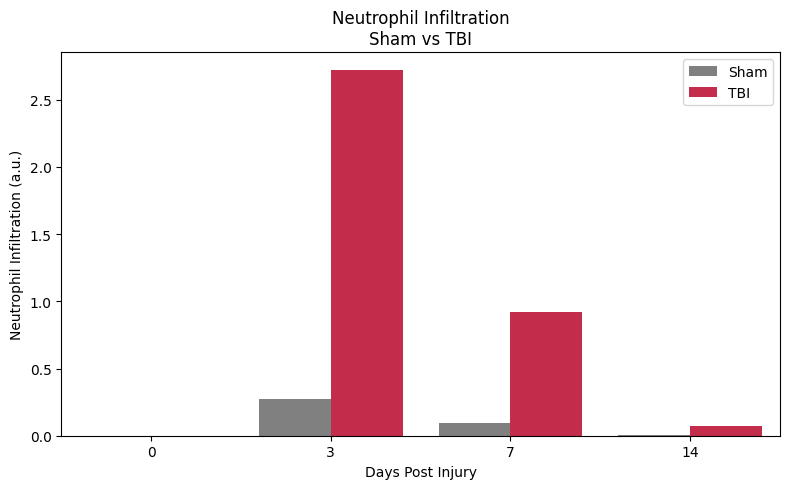

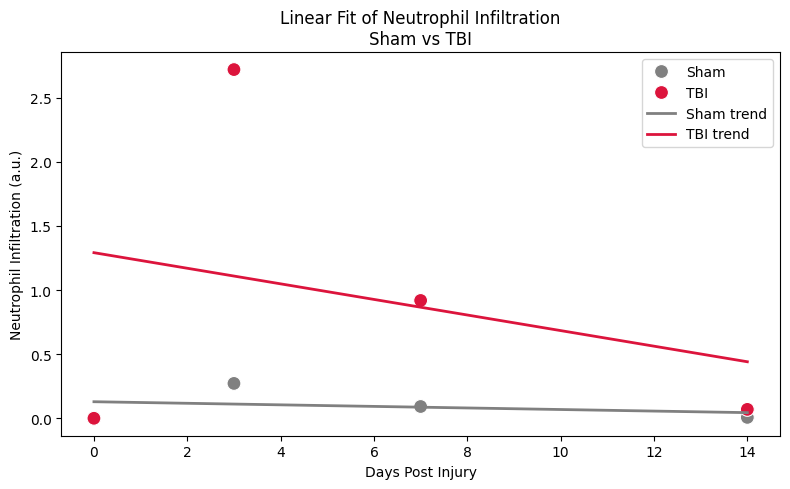

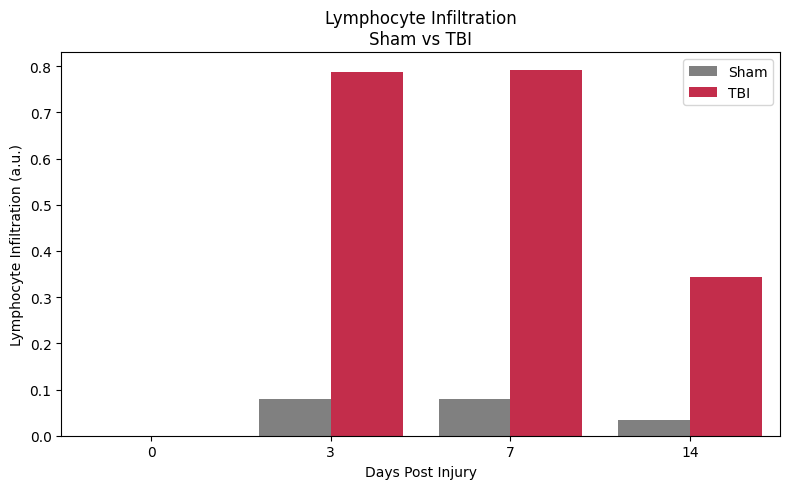

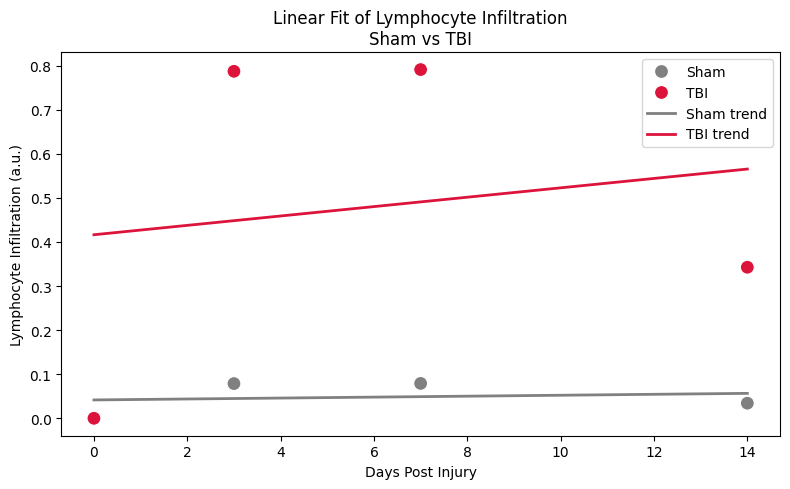

In [6]:
# --- Common setup and ODE model (unchanged) ---
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

# ---------------------------------------
# ODE model
# ---------------------------------------
def immune_infiltration(y, t, params):
    C, N, M, L = y
    alpha_N, alpha_M, alpha_L, beta_N, beta_M, beta_L, gamma_N, gamma_M, k_c = params

    dCdt = -k_c * C
    dNdt = alpha_N * C - beta_N * N
    dMdt = alpha_M * C + gamma_N * N - beta_M * M
    dLdt = alpha_L * C + gamma_M * M - beta_L * L
    return [dCdt, dNdt, dMdt, dLdt]

# Parameters
params = (0.8, 0.3, 0.1, 0.6, 0.3, 0.2, 0.1, 0.05, 0.4)

# Initial conditions
y0_sham = [0.5, 0, 0, 0]
y0_tbi = [5.0, 0, 0, 0]

# Time span (0–14 days)
t = np.linspace(0, 14, 1000)

# Solve ODEs
sol_sham = odeint(immune_infiltration, y0_sham, t, args=(params,))
sol_tbi = odeint(immune_infiltration, y0_tbi, t, args=(params,))


# ---------------------------------------
# Neutrophil-specific simulation and plotting
# ---------------------------------------

# Isolate neutrophil infiltration (N) from the solution
neutrophil_sham = sol_sham[:, 1]
neutrophil_tbi = sol_tbi[:, 1]

# Sample at time points (sham=0, 3, 7, 14 days)
time_points = [0, 3, 7, 14]
idx = [np.argmin(np.abs(t - tp)) for tp in time_points]

neutrophil_data = pd.DataFrame({
    "DaysPostInjury": np.tile(time_points, 2),
    "Infiltration": np.concatenate((neutrophil_sham[idx], neutrophil_tbi[idx])),
    "Condition": ["Sham"] * len(time_points) + ["TBI"] * len(time_points)
})

# --- Neutrophil Bar Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(data=neutrophil_data, x="DaysPostInjury", y="Infiltration", hue="Condition", palette=["gray", "crimson"])
plt.title("Neutrophil Infiltration\nSham vs TBI")
plt.xlabel("Days Post Injury")
plt.ylabel("Neutrophil Infiltration (a.u.)")
plt.legend(title="")
plt.tight_layout()
plt.show()

# --- Neutrophil Trend Plot ---
plt.figure(figsize=(8, 5))
sns.scatterplot(data=neutrophil_data, x="DaysPostInjury", y="Infiltration", hue="Condition", palette=["gray", "crimson"], s=100)

# Add linear fits for neutrophils
x_fit = np.linspace(0, 14, 100).reshape(-1, 1)
model_sham_n = LinearRegression().fit(neutrophil_data[neutrophil_data["Condition"] == "Sham"]["DaysPostInjury"].values.reshape(-1, 1), neutrophil_data[neutrophil_data["Condition"] == "Sham"]["Infiltration"].values)
model_tbi_n = LinearRegression().fit(neutrophil_data[neutrophil_data["Condition"] == "TBI"]["DaysPostInjury"].values.reshape(-1, 1), neutrophil_data[neutrophil_data["Condition"] == "TBI"]["Infiltration"].values)

plt.plot(x_fit, model_sham_n.predict(x_fit), color="gray", lw=2, label="Sham trend")
plt.plot(x_fit, model_tbi_n.predict(x_fit), color="crimson", lw=2, label="TBI trend")

plt.title("Linear Fit of Neutrophil Infiltration\nSham vs TBI")
plt.xlabel("Days Post Injury")
plt.ylabel("Neutrophil Infiltration (a.u.)")
plt.legend()
plt.tight_layout()
plt.show()


# ---------------------------------------
# Lymphocyte-specific simulation and plotting
# ---------------------------------------

# Isolate lymphocyte infiltration (L) from the solution
lymphocyte_sham = sol_sham[:, 3]
lymphocyte_tbi = sol_tbi[:, 3]

# Sample at time points (S3, 7, 14 days)
lymphocyte_data = pd.DataFrame({
    "DaysPostInjury": np.tile(time_points, 2),
    "Infiltration": np.concatenate((lymphocyte_sham[idx], lymphocyte_tbi[idx])),
    "Condition": ["Sham"] * len(time_points) + ["TBI"] * len(time_points)
})

# --- Lymphocyte Bar Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(data=lymphocyte_data, x="DaysPostInjury", y="Infiltration", hue="Condition", palette=["gray", "crimson"])
plt.title("Lymphocyte Infiltration\nSham vs TBI")
plt.xlabel("Days Post Injury")
plt.ylabel("Lymphocyte Infiltration (a.u.)")
plt.legend(title="")
plt.tight_layout()
plt.show()

# --- Lymphocyte Trend Plot ---
plt.figure(figsize=(8, 5))
sns.scatterplot(data=lymphocyte_data, x="DaysPostInjury", y="Infiltration", hue="Condition", palette=["gray", "crimson"], s=100)

# Add linear fits for lymphocytes
model_sham_l = LinearRegression().fit(lymphocyte_data[lymphocyte_data["Condition"] == "Sham"]["DaysPostInjury"].values.reshape(-1, 1), lymphocyte_data[lymphocyte_data["Condition"] == "Sham"]["Infiltration"].values)
model_tbi_l = LinearRegression().fit(lymphocyte_data[lymphocyte_data["Condition"] == "TBI"]["DaysPostInjury"].values.reshape(-1, 1), lymphocyte_data[lymphocyte_data["Condition"] == "TBI"]["Infiltration"].values)

plt.plot(x_fit, model_sham_l.predict(x_fit), color="gray", lw=2, label="Sham trend")
plt.plot(x_fit, model_tbi_l.predict(x_fit), color="crimson", lw=2, label="TBI trend")

plt.title("Linear Fit of Lymphocyte Infiltration\nSham vs TBI")
plt.xlabel("Days Post Injury")
plt.ylabel("Lymphocyte Infiltration (a.u.)")
plt.legend()
plt.tight_layout()
plt.show()




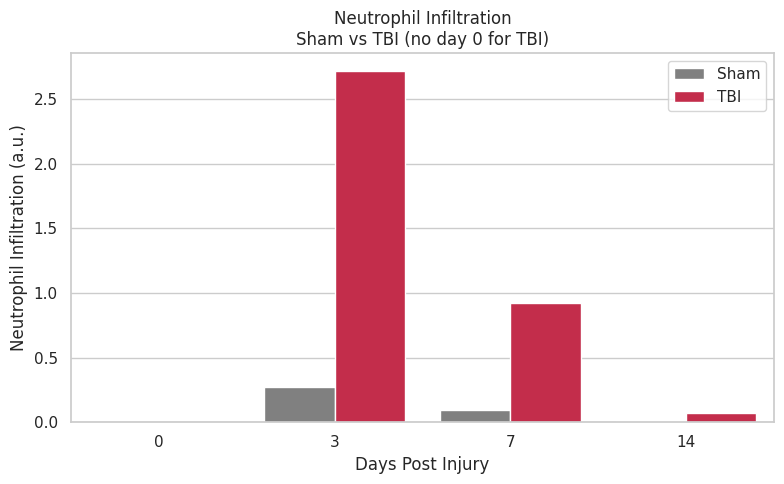

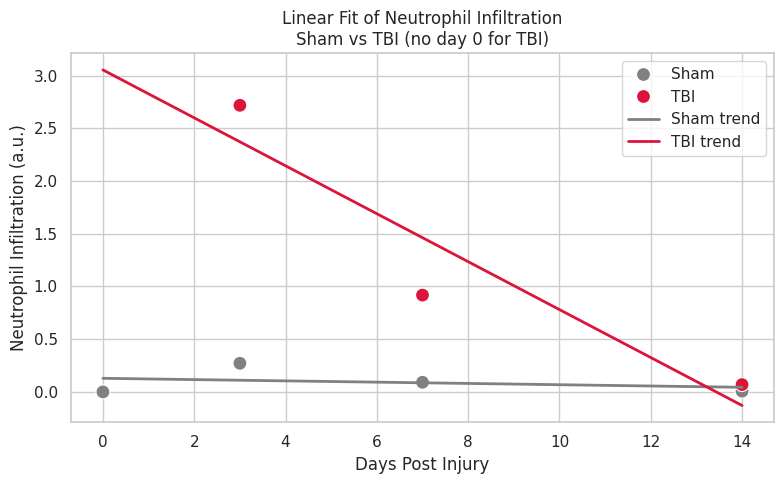

In [15]:
# Filter out timepoint 0 for the TBI group
neutrophil_data_filtered = neutrophil_data[~((neutrophil_data["Condition"] == "TBI") & (neutrophil_data["DaysPostInjury"] == 0))]


# --- Neutrophil Bar Plot ---
plt.figure(figsize=(8, 5))
# Use the filtered data for the plot
sns.barplot(data=neutrophil_data_filtered, x="DaysPostInjury", y="Infiltration", hue="Condition", palette=["gray", "crimson"])
plt.title("Neutrophil Infiltration\nSham vs TBI (no day 0 for TBI)")
plt.xlabel("Days Post Injury")
plt.ylabel("Neutrophil Infiltration (a.u.)")
plt.legend(title="")
plt.tight_layout()
plt.show()


# --- Neutrophil Trend Plot ---
plt.figure(figsize=(8, 5))
# Use the filtered data for the scatter plot
sns.scatterplot(data=neutrophil_data_filtered, x="DaysPostInjury", y="Infiltration", hue="Condition", palette=["gray", "crimson"], s=100)

# Add linear fits for neutrophils (make sure to fit to the filtered data)
x_fit = np.linspace(0, 14, 100).reshape(-1, 1)
model_sham_n = LinearRegression().fit(neutrophil_data[neutrophil_data["Condition"] == "Sham"]["DaysPostInjury"].values.reshape(-1, 1), neutrophil_data[neutrophil_data["Condition"] == "Sham"]["Infiltration"].values)
# Fit the TBI model to the filtered data (TBI group without day 0)
model_tbi_n = LinearRegression().fit(neutrophil_data_filtered[neutrophil_data_filtered["Condition"] == "TBI"]["DaysPostInjury"].values.reshape(-1, 1), neutrophil_data_filtered[neutrophil_data_filtered["Condition"] == "TBI"]["Infiltration"].values)

plt.plot(x_fit, model_sham_n.predict(x_fit), color="gray", lw=2, label="Sham trend")
plt.plot(x_fit, model_tbi_n.predict(x_fit), color="crimson", lw=2, label="TBI trend")

plt.title("Linear Fit of Neutrophil Infiltration\nSham vs TBI (no day 0 for TBI)")
plt.xlabel("Days Post Injury")
plt.ylabel("Neutrophil Infiltration (a.u.)")
plt.legend()
plt.tight_layout()
plt.show()



=== Raw Normality: Neutrophils ===
Sham Shapiro–Wilk: ShapiroResult(statistic=np.float64(0.8405704851583702), pvalue=np.float64(0.19707105551891224))
TBI Shapiro–Wilk: ShapiroResult(statistic=np.float64(0.8405704823330689), pvalue=np.float64(0.19707104723124286))


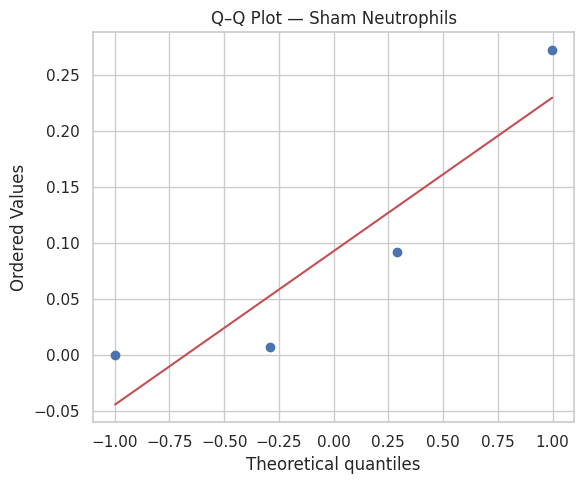

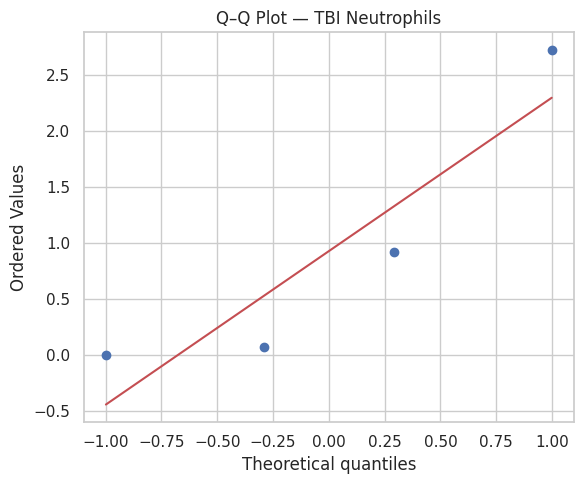


=== Raw Normality: Lymphocytes ===
Sham Shapiro–Wilk: ShapiroResult(statistic=np.float64(0.8661711572067708), pvalue=np.float64(0.282928673543845))
TBI Shapiro–Wilk: ShapiroResult(statistic=np.float64(0.8661711588316776), pvalue=np.float64(0.28292867969721247))


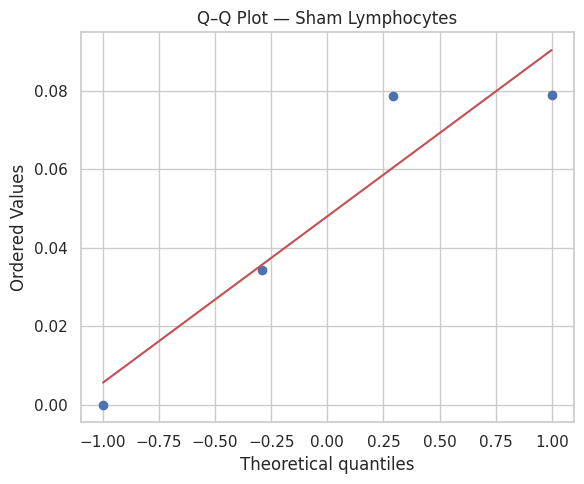

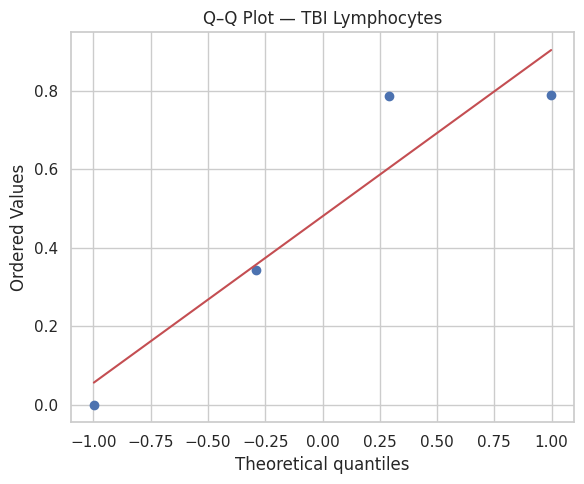


=== Residual Normality: Neutrophils ===
Sham residuals Shapiro–Wilk: ShapiroResult(statistic=np.float64(0.9686087227791484), pvalue=np.float64(0.8328496444840341))
TBI residuals Shapiro–Wilk: ShapiroResult(statistic=np.float64(0.8125034550184514), pvalue=np.float64(0.12660033424536543))


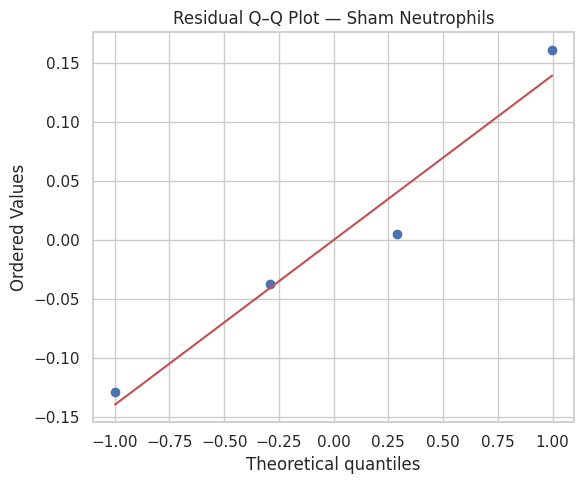

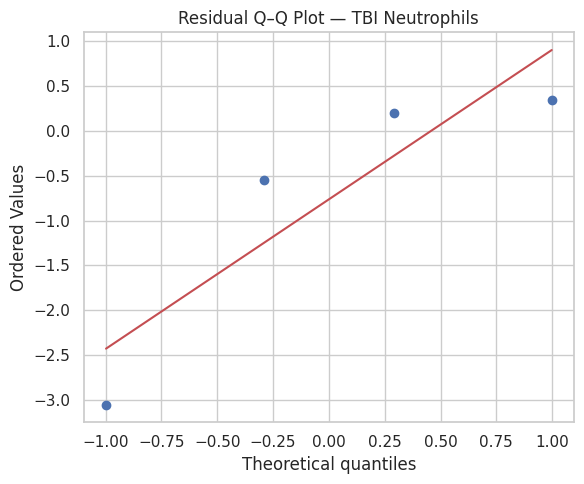


=== Residual Normality: Lymphocytes ===
Sham residuals Shapiro–Wilk: ShapiroResult(statistic=np.float64(0.8582739636451487), pvalue=np.float64(0.25409698407857184))
TBI residuals Shapiro–Wilk: ShapiroResult(statistic=np.float64(0.8582739645865994), pvalue=np.float64(0.2540969873884865))


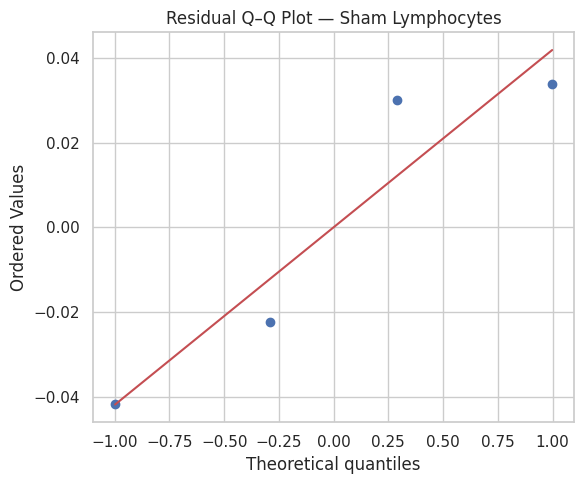

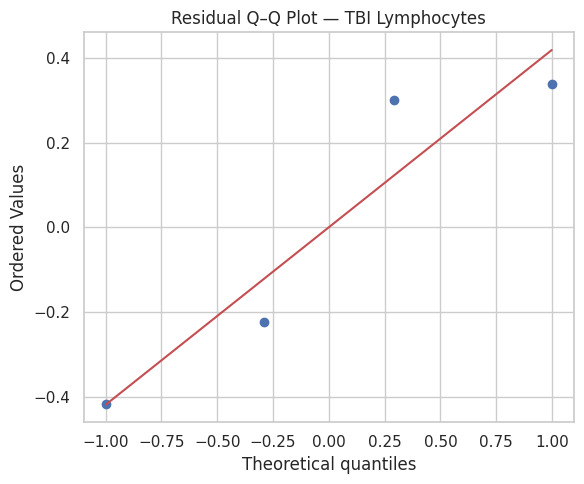

In [33]:
# ====================================================
# NORMALITY CHECKS FOR NEUTROPHILS + LYMPHOCYTES
# ====================================================

import scipy.stats as stats

# ----------------------------------------------------
# 1. NORMALITY OF RAW INFILTRATION VALUES
# ----------------------------------------------------

def check_raw_normality(df, label):
    sham_vals = df[df["Condition"] == "Sham"]["Infiltration"]
    tbi_vals  = df[df["Condition"] == "TBI"]["Infiltration"]

    print(f"\n=== Raw Normality: {label} ===")
    print("Sham Shapiro–Wilk:", stats.shapiro(sham_vals))
    print("TBI Shapiro–Wilk:",  stats.shapiro(tbi_vals))

    # Q–Q plots
    plt.figure(figsize=(6,5))
    stats.probplot(sham_vals, dist="norm", plot=plt)
    plt.title(f"Q–Q Plot — Sham {label}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,5))
    stats.probplot(tbi_vals, dist="norm", plot=plt)
    plt.title(f"Q–Q Plot — TBI {label}")
    plt.tight_layout()
    plt.show()


check_raw_normality(neutrophil_data, "Neutrophils")
check_raw_normality(lymphocyte_data, "Lymphocytes")


# ----------------------------------------------------
# 2. NORMALITY OF REGRESSION RESIDUALS
# ----------------------------------------------------

def check_residual_normality(df, model_sham, model_tbi, label):
    sham_x = df[df["Condition"] == "Sham"]["DaysPostInjury"].values.reshape(-1,1)
    sham_y = df[df["Condition"] == "Sham"]["Infiltration"].values
    sham_pred = model_sham.predict(sham_x)
    sham_resid = sham_y - sham_pred

    tbi_x = df[df["Condition"] == "TBI"]["DaysPostInjury"].values.reshape(-1,1)
    tbi_y = df[df["Condition"] == "TBI"]["Infiltration"].values
    tbi_pred = model_tbi.predict(tbi_x)
    tbi_resid = tbi_y - tbi_pred

    print(f"\n=== Residual Normality: {label} ===")
    print("Sham residuals Shapiro–Wilk:", stats.shapiro(sham_resid))
    print("TBI residuals Shapiro–Wilk:",  stats.shapiro(tbi_resid))

    # Q–Q plots
    plt.figure(figsize=(6,5))
    stats.probplot(sham_resid, dist="norm", plot=plt)
    plt.title(f"Residual Q–Q Plot — Sham {label}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,5))
    stats.probplot(tbi_resid, dist="norm", plot=plt)
    plt.title(f"Residual Q–Q Plot — TBI {label}")
    plt.tight_layout()
    plt.show()


check_residual_normality(neutrophil_data, model_sham_n, model_tbi_n, "Neutrophils")
check_residual_normality(lymphocyte_data, model_sham_l, model_tbi_l, "Lymphocytes")


In [8]:
# ---------------------------------------
# Compute slopes and p-values for each immune cell type
# ---------------------------------------

def compute_slope_pval(df, cell_type):
    results = {}
    for condition in ["Sham", "TBI"]:
        subset = df[df["Condition"] == condition]
        if not subset.empty: # Add a check for empty dataframes
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                subset["DaysPostInjury"], subset["Infiltration"]
            )
            results[condition] = {"slope": slope, "p_value": p_value}
        else:
             results[condition] = {"slope": np.nan, "p_value": np.nan} # Handle empty case
    print(f"\n--- {cell_type} ---")
    for cond, vals in results.items():
        print(f"{cond}: slope = {vals['slope']:.4f}, p = {vals['p_value']:.4e}")
    return results

# --- Recreate dataframes needed for the function ---
# Assuming sol_sham, sol_tbi, t, and time_points are available from a previous cell execution

# Sample at time points (sham=0, 3, 7, 14 days)
idx = [np.argmin(np.abs(t - tp)) for tp in time_points]

# Isolate neutrophil infiltration (N) from the solution
neutrophil_sham = sol_sham[:, 1]
neutrophil_tbi = sol_tbi[:, 1]

neutrophil_data = pd.DataFrame({
    "DaysPostInjury": np.tile(time_points, 2),
    "Infiltration": np.concatenate((neutrophil_sham[idx], neutrophil_tbi[idx])),
    "Condition": ["Sham"] * len(time_points) + ["TBI"] * len(time_points)
})

# Isolate lymphocyte infiltration (L) from the solution
lymphocyte_sham = sol_sham[:, 3]
lymphocyte_tbi = sol_tbi[:, 3]

lymphocyte_data = pd.DataFrame({
    "DaysPostInjury": np.tile(time_points, 2),
    "Infiltration": np.concatenate((lymphocyte_sham[idx], lymphocyte_tbi[idx])),
    "Condition": ["Sham"] * len(time_points) + ["TBI"] * len(time_points)
})

# Isolate macrophages (M) from the solution
macrophage_sham = sol_sham[:, 2]
macrophage_tbi = sol_tbi[:, 2]

macrophage_data = pd.DataFrame({
    "DaysPostInjury": np.tile(time_points, 2),
    "Infiltration": np.concatenate((macrophage_sham[idx], macrophage_tbi[idx])),
    "Condition": ["Sham"] * len(time_points) + ["TBI"] * len(time_points)
})


# Compute for each immune cell
neutrophil_results = compute_slope_pval(neutrophil_data, "Neutrophils")
lymphocyte_results = compute_slope_pval(lymphocyte_data, "Lymphocytes")
macrophage_results = compute_slope_pval(macrophage_data, "Macrophages")


--- Neutrophils ---
Sham: slope = -0.0061, p = 7.0936e-01
TBI: slope = -0.0607, p = 7.0936e-01

--- Lymphocytes ---
Sham: slope = 0.0011, p = 8.3178e-01
TBI: slope = 0.0106, p = 8.3178e-01

--- Macrophages ---
Sham: slope = -0.0022, p = 8.6326e-01
TBI: slope = -0.0220, p = 8.6326e-01


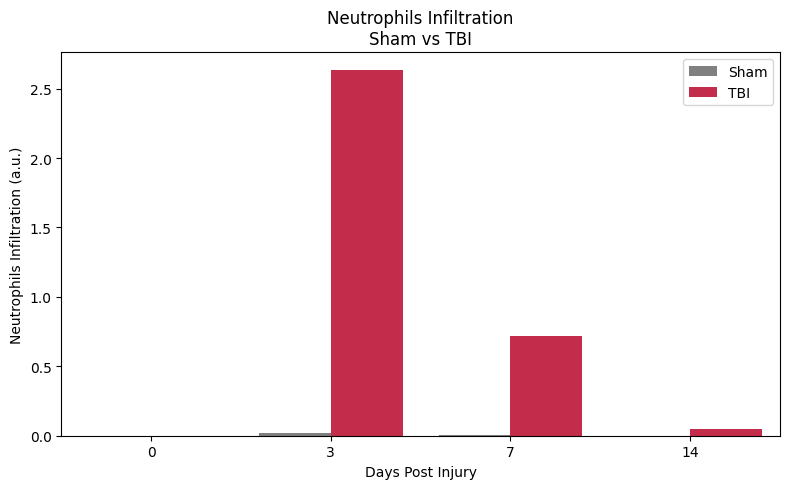

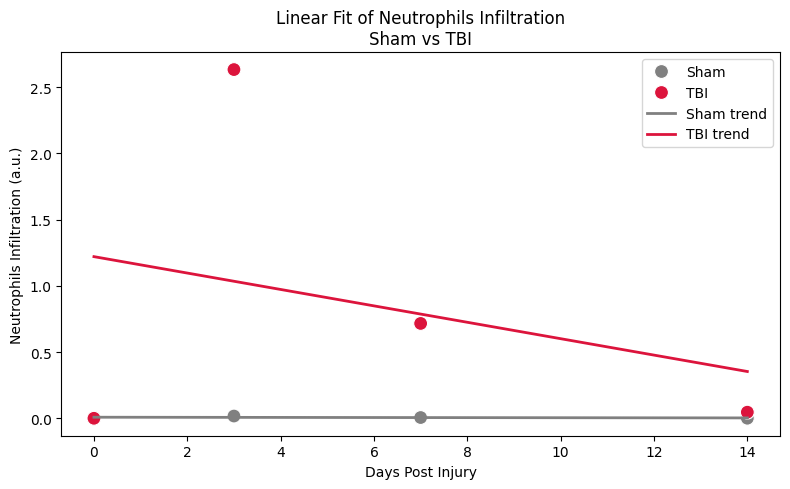

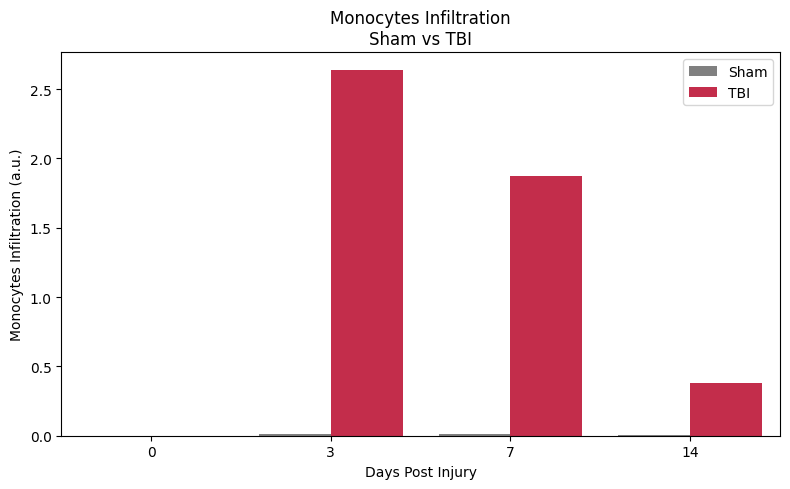

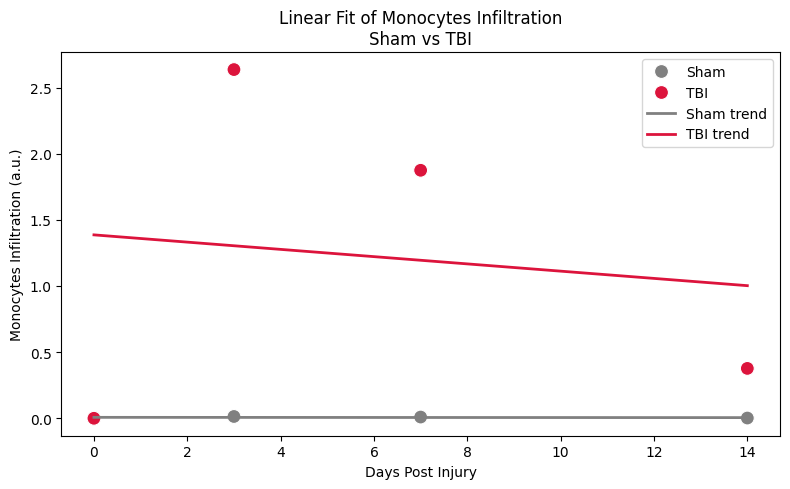

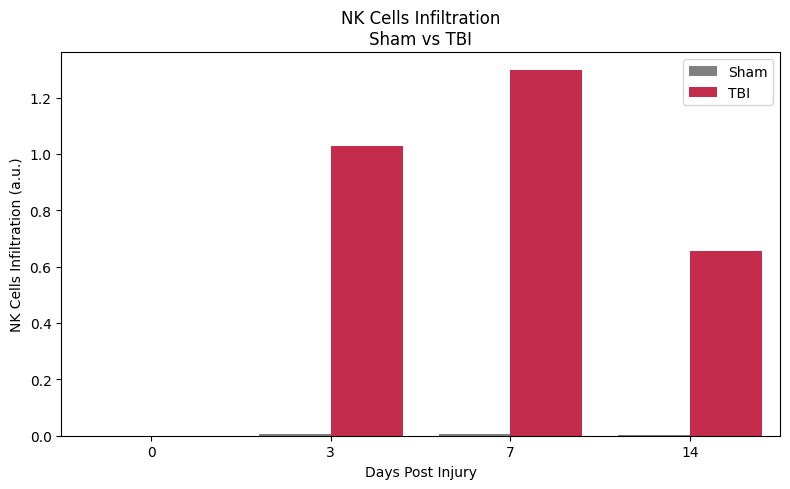

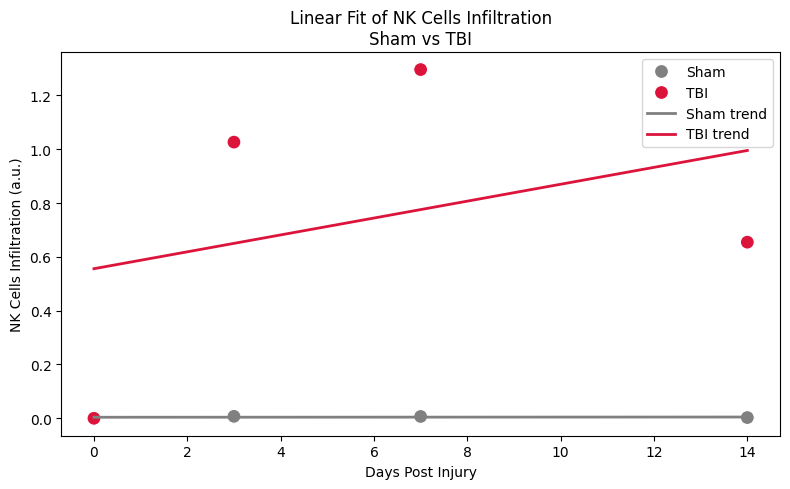

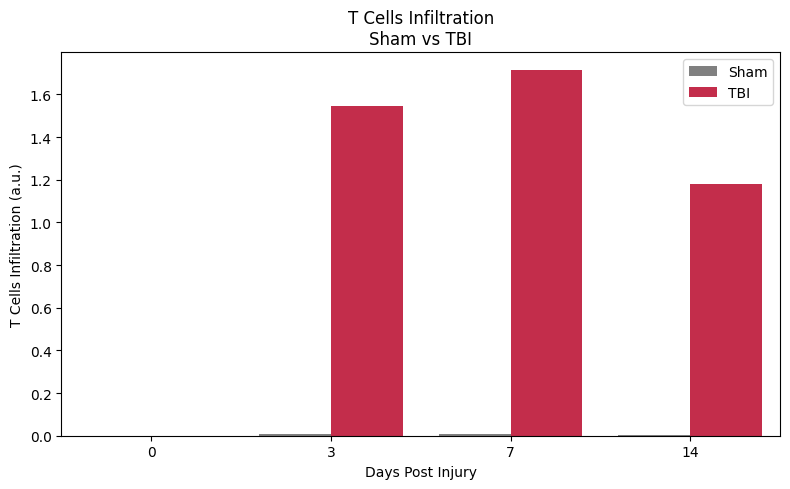

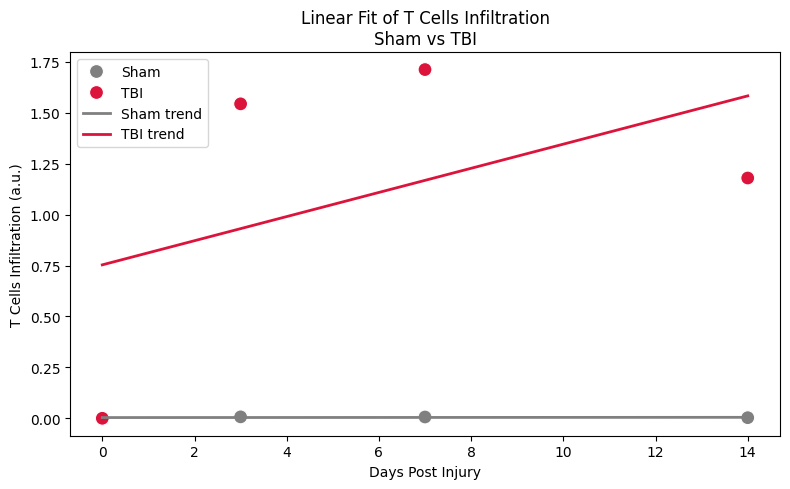

In [9]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

# ---------------------------------------
# Expanded ODE model
# ---------------------------------------
def immune_infiltration_expanded(y, t, params):
    C, N, Mo, NK, T = y
    alpha_N, alpha_Mo, alpha_NK, alpha_T, beta_N, beta_Mo, beta_NK, beta_T, gamma_N, gamma_Mo, gamma_NK, k_c = params

    dCdt = -k_c * C
    dNdt = alpha_N * C - beta_N * N
    dModt = alpha_Mo * C + gamma_N * N - beta_Mo * Mo
    dNKdt = alpha_NK * C + gamma_Mo * Mo - beta_NK * NK
    dTdt = alpha_T * C + gamma_NK * NK - beta_T * T

    return [dCdt, dNdt, dModt, dNKdt, dTdt]

# ---------------------------------------
# Parameters and initial conditions
# ---------------------------------------
# TBI-specific parameters tuned for representative kinetics
params_tbi = (
    1.0,   # alpha_N: Neutrophil recruitment (fast and strong)
    0.3,   # alpha_Mo: Monocyte recruitment
    0.1,   # alpha_NK: NK cell recruitment
    0.2,   # alpha_T: T cell recruitment (slower, sustained)
    0.8,   # beta_N: Neutrophil decay (fast)
    0.3,   # beta_Mo: Monocyte decay
    0.2,   # beta_NK: NK cell decay
    0.1,   # beta_T: T cell decay (slow, sustained)
    0.2,   # gamma_N: Neutrophil effect on monocytes
    0.1,   # gamma_Mo: Monocyte effect on NK cells
    0.05,  # gamma_NK: NK cell effect on T cells
    0.4    # k_c: Injury signal decay rate
)

# Sham parameters (minimal or no immune response)
params_sham = (
    0.05,  # alpha_N
    0.02,  # alpha_Mo
    0.01,  # alpha_NK
    0.01,  # alpha_T
    0.6,   # beta_N
    0.3,   # beta_Mo
    0.2,   # beta_NK
    0.15,  # beta_T
    0.1,   # gamma_N
    0.05,  # gamma_Mo
    0.02,  # gamma_NK
    0.4    # k_c
)

# Initial conditions for [C, N, Mo, NK, T]
y0_sham = [0.5, 0, 0, 0, 0]
y0_tbi = [5.0, 0, 0, 0, 0]

# Time span (0–14 days)
t = np.linspace(0, 14, 1000)

# Solve ODEs for Sham and TBI
sol_sham = odeint(immune_infiltration_expanded, y0_sham, t, args=(params_sham,))
sol_tbi = odeint(immune_infiltration_expanded, y0_tbi, t, args=(params_tbi,))

# ---------------------------------------
# Data processing and plotting
# ---------------------------------------
time_points = [0, 3, 7, 14]
idx = [np.argmin(np.abs(t - tp)) for tp in time_points]

cell_populations = ['Neutrophils', 'Monocytes', 'NK Cells', 'T Cells']
# Indices in the solution matrix for each cell type: [C, N, Mo, NK, T]
sol_indices = [1, 2, 3, 4]

# Loop through each cell population to create individual plots
for i, cell_name in enumerate(cell_populations):
    sol_idx = sol_indices[i]

    # Extract data for the specific cell type
    cell_sham = sol_sham[:, sol_idx]
    cell_tbi = sol_tbi[:, sol_idx]

    # Create DataFrame for bar plot
    data = pd.DataFrame({
        "DaysPostInjury": np.tile(time_points, 2),
        "Infiltration": np.concatenate((cell_sham[idx], cell_tbi[idx])),
        "Condition": ["Sham"] * len(time_points) + ["TBI"] * len(time_points)
    })

    # --- Bar Plot ---
    plt.figure(figsize=(8, 5))
    sns.barplot(data=data, x="DaysPostInjury", y="Infiltration", hue="Condition", palette=["gray", "crimson"])
    plt.title(f"{cell_name} Infiltration\nSham vs TBI")
    plt.xlabel("Days Post Injury")
    plt.ylabel(f"{cell_name} Infiltration (a.u.)")
    plt.legend(title="")
    plt.tight_layout()
    plt.show()

    # --- Trend Plot ---
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=data, x="DaysPostInjury", y="Infiltration", hue="Condition", palette=["gray", "crimson"], s=100)

    # Add linear fits
    x_fit = np.linspace(0, 14, 100).reshape(-1, 1)
    model_sham = LinearRegression().fit(data[data["Condition"] == "Sham"]["DaysPostInjury"].values.reshape(-1, 1), data[data["Condition"] == "Sham"]["Infiltration"].values)
    model_tbi = LinearRegression().fit(data[data["Condition"] == "TBI"]["DaysPostInjury"].values.reshape(-1, 1), data[data["Condition"] == "TBI"]["Infiltration"].values)

    plt.plot(x_fit, model_sham.predict(x_fit), color="gray", lw=2, label="Sham trend")
    plt.plot(x_fit, model_tbi.predict(x_fit), color="crimson", lw=2, label="TBI trend")

    plt.title(f"Linear Fit of {cell_name} Infiltration\nSham vs TBI")
    plt.xlabel("Days Post Injury")
    plt.ylabel(f"{cell_name} Infiltration (a.u.)")
    plt.legend()
    plt.tight_layout()
    plt.show()

     Subject  Time_Point Group    Cell_Type  Cell_Count
0  Subject_0           0  Sham    Monocytes   22.483571
1  Subject_0           0  Sham  Neutrophils   49.308678
2  Subject_0           0  Sham  Lymphocytes  103.238443
3  Subject_0           3   TBI    Monocytes   42.615149
4  Subject_0           3   TBI  Neutrophils   78.829233


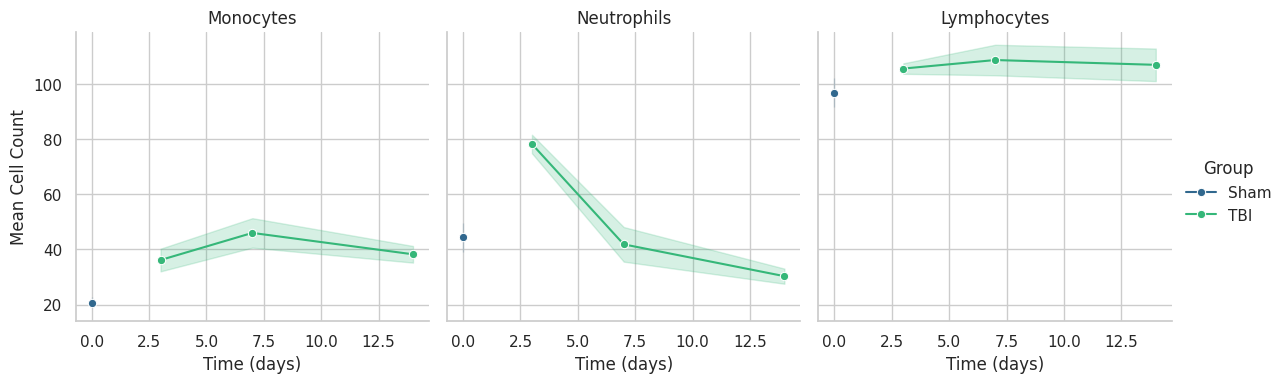


--- Fitting linear model for Monocytes ---
                            OLS Regression Results                            
Dep. Variable:             Cell_Count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.076
Method:                 Least Squares   F-statistic:                   0.01520
Date:                Wed, 03 Dec 2025   Prob (F-statistic):              0.904
Time:                        03:03:24   Log-Likelihood:                -47.370
No. Observations:                  15   AIC:                             98.74
Df Residuals:                      13   BIC:                             100.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

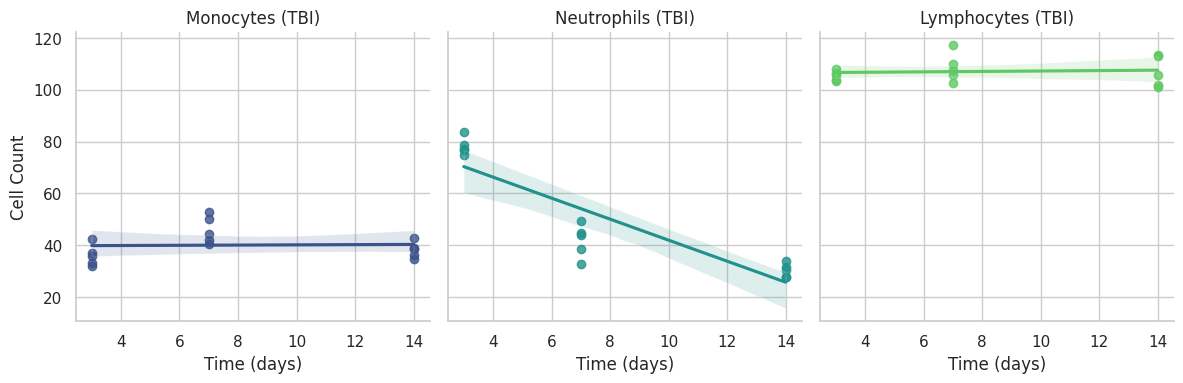

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: Set a consistent plotting style
sns.set_theme(style="whitegrid")


# Set up experimental parameters
n_subjects = 5  # Number of subjects per group
time_points = [0, 3, 7, 14]  # Time in days (0=Sham)
cell_types = ['Monocytes', 'Neutrophils', 'Lymphocytes']

# Set the average effect for each cell type over time
# These numbers are for demonstration and mimic known TBI immune dynamics.
# For a real experiment, these would be based on prior research.
# We will use simple linear trends for modeling purposes.
effects = {
    'Monocytes': [20, 35, 45, 40], # Increase then plateau
    'Neutrophils': [50, 80, 40, 30], # Rapid increase then decline
    'Lymphocytes': [100, 105, 110, 108] # Small, gradual increase
}

# Generate data
data = []
for subject_id in range(n_subjects):
    for t_idx, time_point in enumerate(time_points):
        group = 'Sham' if time_point == 0 else 'TBI'

        # Add random noise to the mean effects for each subject and cell type
        for cell_type in cell_types:
            mean_count = effects[cell_type][t_idx]
            simulated_count = np.random.normal(mean_count, scale=5)  # Add Gaussian noise

            data.append({
                'Subject': f'Subject_{subject_id}',
                'Time_Point': time_point,
                'Group': group,
                'Cell_Type': cell_type,
                'Cell_Count': max(0, simulated_count)  # Ensure non-negative counts
            })

# Create a pandas DataFrame
df = pd.DataFrame(data)
print(df.head())


# Create a plot for each cell type
g = sns.FacetGrid(df, col="Cell_Type", hue="Group", col_wrap=3, height=4, palette="viridis")
g.map(sns.lineplot, "Time_Point", "Cell_Count", marker="o", errorbar="sd")
g.add_legend()
g.set_axis_labels("Time (days)", "Mean Cell Count")
g.set_titles(col_template="{col_name}")
plt.show()


import statsmodels.formula.api as smf

# Fit a linear model for each cell type
models = {}
for cell_type in cell_types:
    print(f"\n--- Fitting linear model for {cell_type} ---")

    # Filter for the current cell type and only TBI group (since Sham is a single time point)
    df_cell = df[(df['Cell_Type'] == cell_type) & (df['Group'] == 'TBI')]

    if not df_cell.empty:
        # Define the model formula
        # The formula 'Cell_Count ~ Time_Point' tests if time has a significant effect on cell counts
        model_formula = 'Cell_Count ~ Time_Point'

        # Fit the model
        model = smf.ols(formula=model_formula, data=df_cell).fit()
        models[cell_type] = model

        # Print the summary
        print(model.summary())
    else:
        print(f"No TBI data found for {cell_type}.")



# Create an lmplot for each cell type, showing the regression line for the TBI group
g = sns.lmplot(
    data=df[df['Group'] == 'TBI'],
    x="Time_Point",
    y="Cell_Count",
    col="Cell_Type",
    hue="Cell_Type",
    col_wrap=3,
    height=4,
    palette="viridis",
    ci=95  # Plot 95% confidence interval
)
g.set_axis_labels("Time (days)", "Cell Count")
g.set_titles(col_template="{col_name} (TBI)")
plt.show()


<Figure size 1200x800 with 0 Axes>

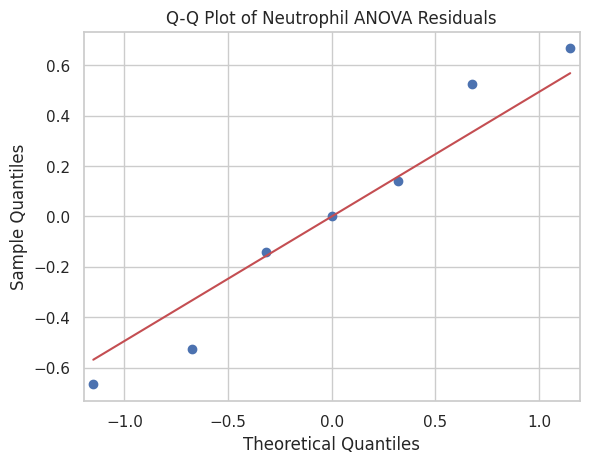

Shapiro-Wilk Test for Normality of Residuals: p-value = 0.7781967413599457
ANOVA for Lymphocytes (without interaction):
                     sum_sq   df          F    PR(>F)
C(Condition)       0.497891  1.0  18.510246  0.050006
C(DaysPostInjury)  0.083436  3.0   1.033972  0.525927
Residual           0.053796  2.0        NaN       NaN


<Figure size 1200x800 with 0 Axes>

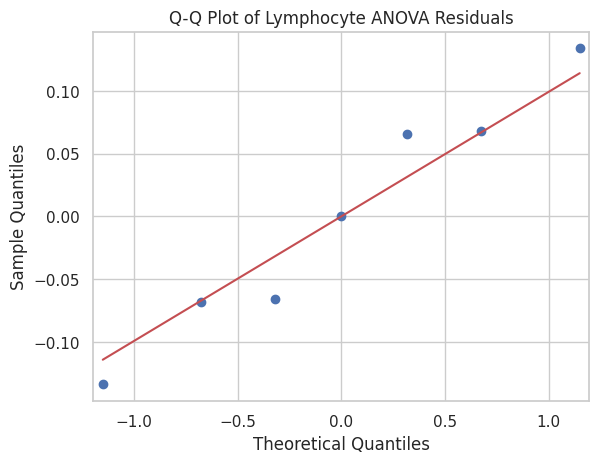

In [31]:
#Normality Check

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming 'neutrophil_data_filtered' is your DataFrame
# Fit the two-way ANOVA model WITHOUT the interaction term, as the filtered data creates an unbalanced design
model_neutro_interaction = ols('Infiltration ~ C(Condition) + C(DaysPostInjury)', data=neutrophil_data_filtered).fit()

# Plot the residuals
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(model_neutro_interaction.resid, line='q')
plt.title("Q-Q Plot of Neutrophil ANOVA Residuals")
plt.show()

# You can also use a statistical test like Shapiro-Wilk (from scipy)
from scipy.stats import shapiro
stat, p_value = shapiro(model_neutro_interaction.resid)
print(f"Shapiro-Wilk Test for Normality of Residuals: p-value = {p_value}")

#The normality assumption applies to the residuals, not the raw data itself. the residuals did not show a statistically significant deviation from normality,
#thus supporting the use of ANOVA.


#Lymphocytes
# Fit the two-way ANOVA model WITHOUT the interaction term
model_lymph_interaction = ols('Infiltration ~ C(Condition) + C(DaysPostInjury)', data=lymphocyte_data_filtered).fit()

# Print the ANOVA table
anova_table_lymph_interaction = sm.stats.anova_lm(model_lymph_interaction, typ=2)
print("ANOVA for Lymphocytes (without interaction):")
print(anova_table_lymph_interaction)
# Q-Q Plot
fig = plt.figure(figsize=(12, 8))
sm.graphics.qqplot(model_lymph_interaction.resid, line='q')
plt.title("Q-Q Plot of Lymphocyte ANOVA Residuals")
plt.show()


In [22]:
#Statistical analysis
#either parametric or non parametric (this will be based on the normality check)

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the two-way ANOVA model without interaction term
# Using the original neutrophil_data which includes Day 0 for TBI with Infiltration=0
model = ols('Infiltration ~ C(Condition) + C(DaysPostInjury)', data=neutrophil_data).fit()

# View the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA for Neutrophils (without interaction):")
print(anova_table)

# Repeat for lymphocyte data, without interaction term
model_lymph = ols('Infiltration ~ C(Condition) + C(DaysPostInjury)', data=lymphocyte_data).fit()
anova_table_lymph = sm.stats.anova_lm(model_lymph, typ=2)
print("\nANOVA for Lymphocytes (without interaction):")
print(anova_table_lymph)

ANOVA for Neutrophils (without interaction):
                     sum_sq   df         F    PR(>F)
C(Condition)       1.390786  1.0  2.144644  0.239290
C(DaysPostInjury)  2.906208  3.0  1.493827  0.374765
Residual           1.945478  3.0       NaN       NaN

ANOVA for Lymphocytes (without interaction):
                     sum_sq   df         F    PR(>F)
C(Condition)       0.373418  1.0  6.284069  0.087182
C(DaysPostInjury)  0.266303  3.0  1.493827  0.374765
Residual           0.178269  3.0       NaN       NaN


Required sample size per group: 26.0


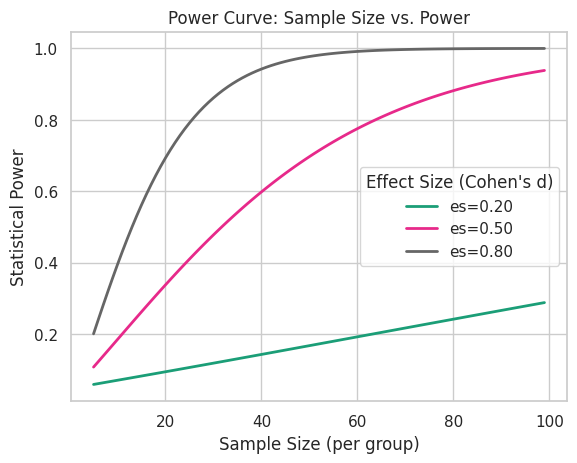

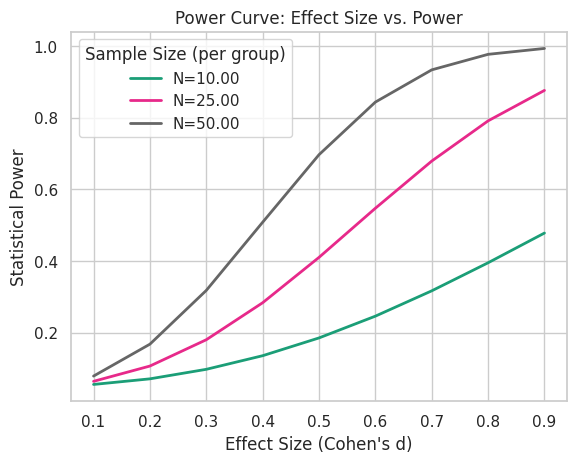

In [19]:
import numpy as np
from statsmodels.stats.power import TTestIndPower

--------POWER CURVES----------
# Example parameters
effect = 0.8  # Assume a large effect size for demonstration
alpha = 0.05
power = 0.80
ratio = 1.0  # Equal sample sizes

# Create a power analysis object
analysis = TTestIndPower()

# Calculate the required sample size per group
sample_size = analysis.solve_power(effect_size=effect, alpha=alpha, power=power, ratio=ratio)

print(f"Required sample size per group: {np.ceil(sample_size)}")

import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
import numpy as np

# Create a power analysis object
power_analysis = TTestIndPower()

# Plot the relationship between sample size and power for different effect sizes
fig = power_analysis.plot_power(
    dep_var='nobs',       # Independent variable: sample size ('nobs')
    nobs=np.arange(5, 100), # Range of sample sizes to test
    effect_size=np.array([0.2, 0.5, 0.8]), # Effect sizes to plot
    alpha=0.05            # Significance level
)
plt.title("Power Curve: Sample Size vs. Power")
plt.xlabel("Sample Size (per group)")
plt.ylabel("Statistical Power")
plt.legend(title="Effect Size (Cohen's d)")
plt.grid(True)
plt.show()

# Plot the relationship between effect size and power for different sample sizes
fig = power_analysis.plot_power(
    dep_var='effect_size', # Independent variable: effect size ('effect_size')
    effect_size=np.arange(0.1, 1.0, 0.1),
    nobs=np.array([10, 25, 50]),
    alpha=0.05
)
plt.title("Power Curve: Effect Size vs. Power")
plt.xlabel("Effect Size (Cohen's d)")
plt.ylabel("Statistical Power")
plt.legend(title="Sample Size (per group)")
plt.grid(True)
plt.show()


/tmp/ipython-input-405886319.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([0, 3, 7, 14])
/tmp/ipython-input-405886319.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([0, 3, 7, 14])
/tmp/ipython-input-405886319.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([0, 3, 7, 14])


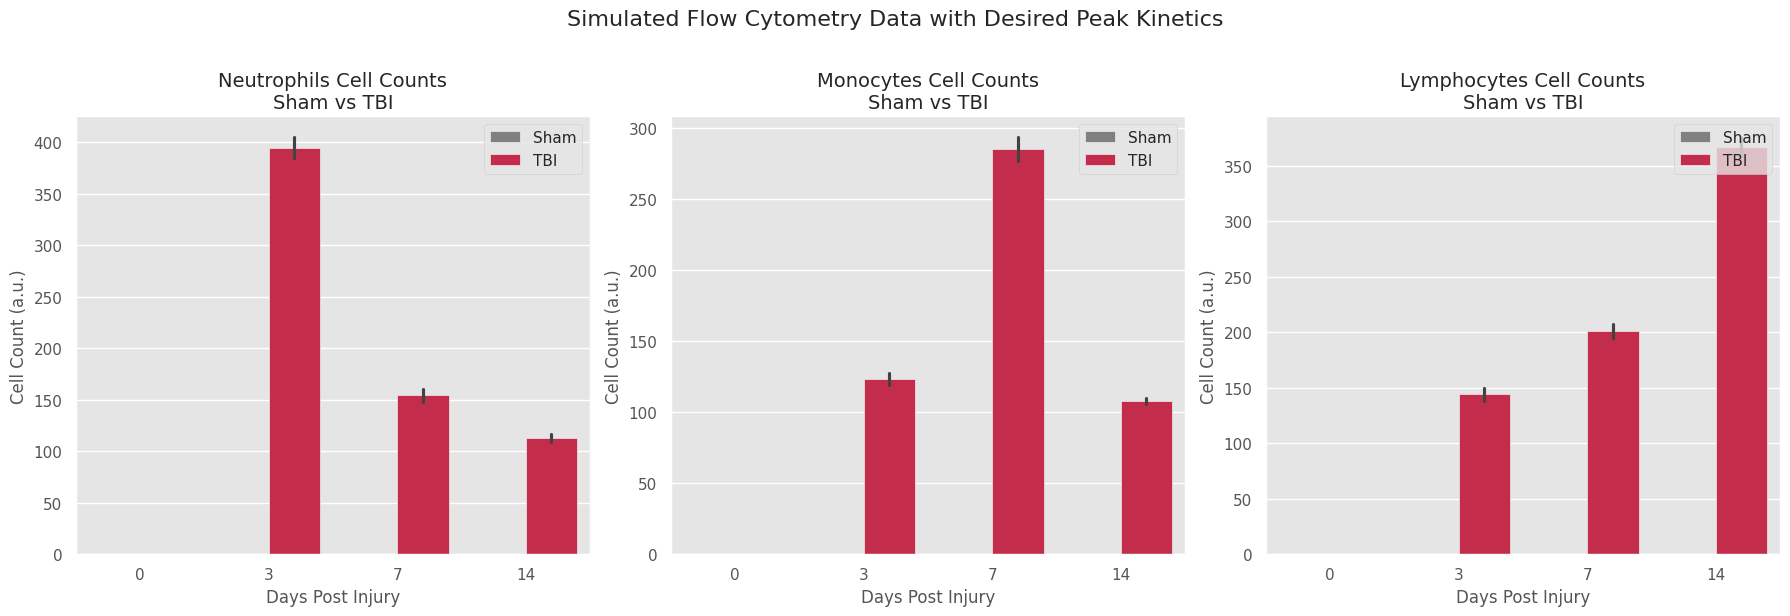


====================== Statistical Analysis for Neutrophils ======================

Two-Way ANOVA Results (with interaction):
                                      sum_sq    df             F        PR(>F)
C(Condition)                    1.389632e-08   1.0  4.025305e-11  9.999950e-01
C(DaysPostInjury)               5.030288e+05   3.0  4.857028e+02  1.150313e-58
C(Condition):C(DaysPostInjury)  1.439632e+06   3.0  1.390046e+03  3.839769e-80
Residual                        3.383195e+04  98.0           NaN           NaN

Shapiro-Wilk Test for Normality of Residuals: p-value = 0.0000


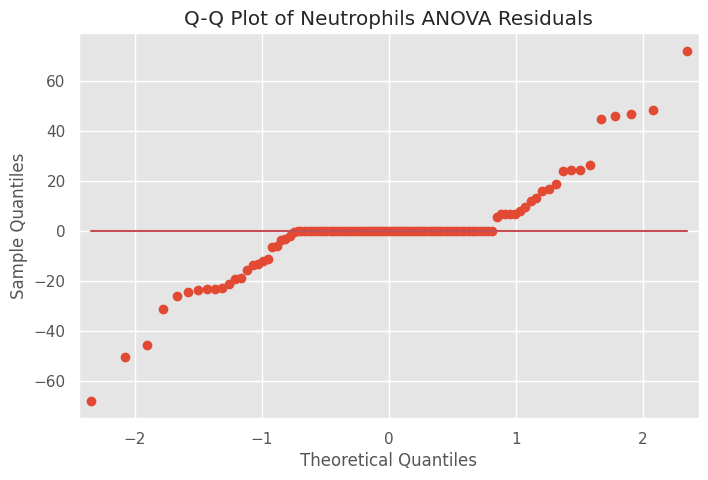


Significant interaction detected. Running Tukey's HSD Post-Hoc Test.


/tmp/ipython-input-405886319.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data['group'] = cell_data['Condition'] + '_' + cell_data['DaysPostInjury'].astype(str)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1  group2  meandiff p-adj   lower     upper   reject
----------------------------------------------------------
 Sham_0 Sham_14       0.0   1.0  -20.4246   20.4246  False
 Sham_0  Sham_3       0.0   1.0  -20.4246   20.4246  False
 Sham_0  Sham_7       0.0   1.0  -20.4246   20.4246  False
 Sham_0  TBI_14  112.5815   0.0   92.1569  133.0061   True
 Sham_0   TBI_3  394.3289   0.0  373.9043  414.7536   True
 Sham_0   TBI_7  154.2108   0.0  133.7862  174.6354   True
Sham_14  Sham_3       0.0   1.0  -20.4246   20.4246  False
Sham_14  Sham_7       0.0   1.0  -20.4246   20.4246  False
Sham_14  TBI_14  112.5815   0.0   92.1569  133.0061   True
Sham_14   TBI_3  394.3289   0.0  373.9043  414.7536   True
Sham_14   TBI_7  154.2108   0.0  133.7862  174.6354   True
 Sham_3  Sham_7       0.0   1.0  -20.4246   20.4246  False
 Sham_3  TBI_14  112.5815   0.0   92.1569  133.0061   True
 Sham_3   TBI_3  394.3289   0.0  373.9043  414.7536   Tr

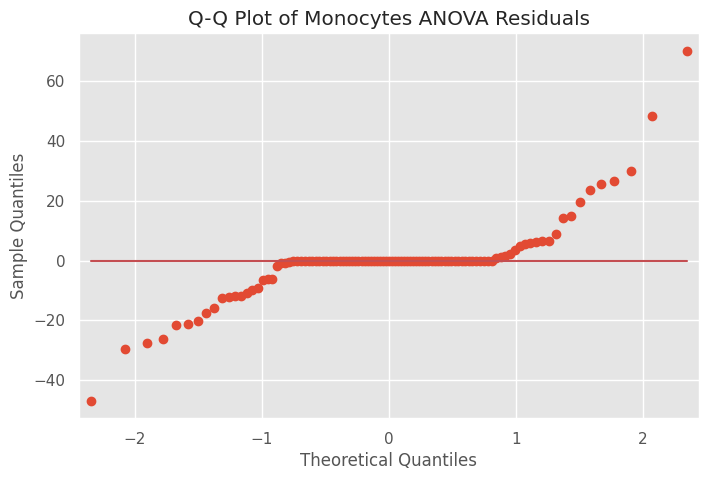


Significant interaction detected. Running Tukey's HSD Post-Hoc Test.


/tmp/ipython-input-405886319.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data['group'] = cell_data['Condition'] + '_' + cell_data['DaysPostInjury'].astype(str)


  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1  group2 meandiff p-adj   lower    upper   reject
--------------------------------------------------------
 Sham_0 Sham_14      0.0    1.0 -15.1597  15.1597  False
 Sham_0  Sham_3      0.0    1.0 -15.1597  15.1597  False
 Sham_0  Sham_7      0.0    1.0 -15.1597  15.1597  False
 Sham_0  TBI_14 107.7776    0.0  92.6179 122.9372   True
 Sham_0   TBI_3 123.4582    0.0 108.2985 138.6178   True
 Sham_0   TBI_7 285.5635    0.0 270.4039 300.7232   True
Sham_14  Sham_3      0.0    1.0 -15.1597  15.1597  False
Sham_14  Sham_7      0.0    1.0 -15.1597  15.1597  False
Sham_14  TBI_14 107.7776    0.0  92.6179 122.9372   True
Sham_14   TBI_3 123.4582    0.0 108.2985 138.6178   True
Sham_14   TBI_7 285.5635    0.0 270.4039 300.7232   True
 Sham_3  Sham_7      0.0    1.0 -15.1597  15.1597  False
 Sham_3  TBI_14 107.7776    0.0  92.6179 122.9372   True
 Sham_3   TBI_3 123.4582    0.0 108.2985 138.6178   True
 Sham_3   TBI_7 285.5635    0.0

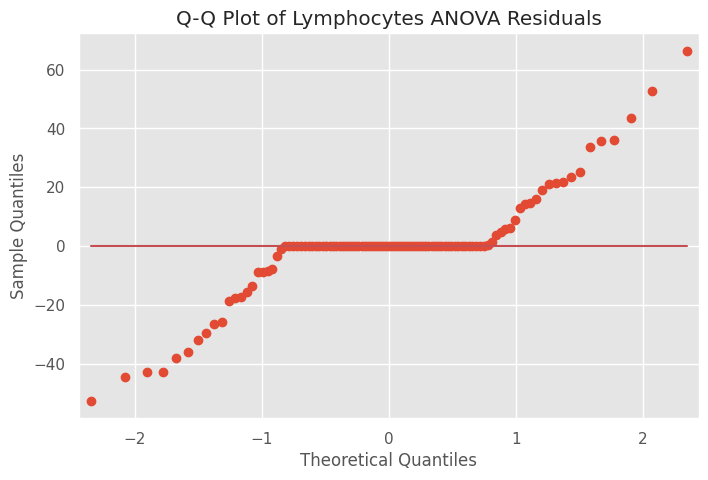


Significant interaction detected. Running Tukey's HSD Post-Hoc Test.


/tmp/ipython-input-405886319.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data['group'] = cell_data['Condition'] + '_' + cell_data['DaysPostInjury'].astype(str)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1  group2  meandiff p-adj   lower     upper   reject
----------------------------------------------------------
 Sham_0 Sham_14       0.0   1.0  -20.1079   20.1079  False
 Sham_0  Sham_3       0.0   1.0  -20.1079   20.1079  False
 Sham_0  Sham_7       0.0   1.0  -20.1079   20.1079  False
 Sham_0  TBI_14  366.6343   0.0  346.5264  386.7423   True
 Sham_0   TBI_3  144.1661   0.0  124.0582   164.274   True
 Sham_0   TBI_7  201.3727   0.0  181.2648  221.4806   True
Sham_14  Sham_3       0.0   1.0  -20.1079   20.1079  False
Sham_14  Sham_7       0.0   1.0  -20.1079   20.1079  False
Sham_14  TBI_14  366.6343   0.0  346.5264  386.7423   True
Sham_14   TBI_3  144.1661   0.0  124.0582   164.274   True
Sham_14   TBI_7  201.3727   0.0  181.2648  221.4806   True
 Sham_3  Sham_7       0.0   1.0  -20.1079   20.1079  False
 Sham_3  TBI_14  366.6343   0.0  346.5264  386.7423   True
 Sham_3   TBI_3  144.1661   0.0  124.0582   164.274   Tr

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro

def simulate_flow_cytometry_data(mean_values, std_devs, conditions, time_points, n_subjects):
    """
    Simulates flow cytometry cell count data with added Gaussian noise.
    """
    all_data = []
    cell_types = list(mean_values.keys())

    for cell_type in cell_types:
        for condition in conditions:
            for time_point in time_points:
                mean = mean_values[cell_type][condition][time_point]
                std = std_devs[cell_type][condition][time_point]
                # Generate cell counts with noise, ensuring they are non-negative
                sim_data = np.maximum(0, np.random.normal(mean, std, n_subjects))

                # Create DataFrame for this group
                df = pd.DataFrame({
                    "CellType": cell_type,
                    "Condition": condition,
                    "DaysPostInjury": time_point,
                    "Count": sim_data
                })
                all_data.append(df)

    return pd.concat(all_data, ignore_index=True)

# -------------------------------------------------------------
# 1. Define simulation parameters and run the simulation (ADJUSTED PEAKS AND SHAM)
# -------------------------------------------------------------
mean_values = {
    'Neutrophils': {
        'Sham': {0: 0.01, 3: 0.01, 7: 0.01, 14: 0.01}, # All sham values set to near zero
        'TBI': {0: 100, 3: 400, 7: 150, 14: 110} # Peak at day 3
    },
    'Monocytes': {
        'Sham': {0: 0.01, 3: 0.01, 7: 0.01, 14: 0.01}, # All sham values set to near zero
        'TBI': {0: 80, 3: 120, 7: 280, 14: 100} # Peak at day 7
    },
    'Lymphocytes': {
        'Sham': {0: 0.01, 3: 0.01, 7: 0.01, 14: 0.01}, # All sham values set to near zero
        'TBI': {0: 300, 3: 150, 7: 200, 14: 350} # Drop then peak at day 14 (recovery/secondary response)
    }
}

# Set standard deviations to zero for the sham group
std_devs = {
    'Neutrophils': {'Sham': {0: 0, 3: 0, 7: 0, 14: 0}, 'TBI': {0: 10, 3: 40, 7: 20, 14: 15}},
    'Monocytes': {'Sham': {0: 0, 3: 0, 7: 0, 14: 0}, 'TBI': {0: 8, 3: 15, 7: 30, 14: 12}},
    'Lymphocytes': {'Sham': {0: 0, 3: 0, 7: 0, 14: 0}, 'TBI': {0: 30, 3: 20, 7: 25, 14: 40}}
}

conditions = ['Sham', 'TBI']
time_points = [0, 3, 7, 14]
n_subjects = 15

# Generate the data
simulated_data = simulate_flow_cytometry_data(mean_values, std_devs, conditions, time_points, n_subjects)

# -------------------------------------------------------------
# 2. Filter the data (remove TBI at Day 0)
# -------------------------------------------------------------
simulated_data_filtered = simulated_data[~((simulated_data["Condition"] == "TBI") & (simulated_data["DaysPostInjury"] == 0))].copy()

# -------------------------------------------------------------
# 3. Visualization (Using Bar Plots)
# -------------------------------------------------------------
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
cell_types = ['Neutrophils', 'Monocytes', 'Lymphocytes']

for i, cell_type in enumerate(cell_types):
    cell_data = simulated_data_filtered[simulated_data_filtered['CellType'] == cell_type]

    sns.barplot(data=cell_data, x="DaysPostInjury", y="Count", hue="Condition", palette=["gray", "crimson"], ax=axes[i], errorbar="se")

    axes[i].set_title(f'{cell_type} Cell Counts\nSham vs TBI', fontsize=14)
    axes[i].set_xlabel('Days Post Injury', fontsize=12)
    axes[i].set_ylabel('Cell Count (a.u.)', fontsize=12)
    axes[i].legend(title='', loc='upper right')
    axes[i].set_xticklabels([0, 3, 7, 14])

plt.suptitle("Simulated Flow Cytometry Data with Desired Peak Kinetics", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4. Statistical Analysis (for rigor)
# -------------------------------------------------------------
for cell_type in ['Neutrophils', 'Monocytes', 'Lymphocytes']:
    print(f"\n====================== Statistical Analysis for {cell_type} ======================")
    cell_data = simulated_data_filtered[simulated_data_filtered['CellType'] == cell_type]

    # Perform Two-Way ANOVA with interaction
    model = ols('Count ~ C(Condition) * C(DaysPostInjury)', data=cell_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("\nTwo-Way ANOVA Results (with interaction):")
    print(anova_table)

    # Check normality of residuals
    stat, p_value_shapiro = shapiro(model.resid)
    print(f"\nShapiro-Wilk Test for Normality of Residuals: p-value = {p_value_shapiro:.4f}")

    # Visual check with Q-Q plot
    fig, ax = plt.subplots(figsize=(8, 5))
    sm.graphics.qqplot(model.resid, line='q', ax=ax)
    ax.set_title(f"Q-Q Plot of {cell_type} ANOVA Residuals")
    plt.show()

    # Perform post-hoc test if interaction is significant
    if anova_table.loc['C(Condition):C(DaysPostInjury)', 'PR(>F)'] < 0.05:
        print("\nSignificant interaction detected. Running Tukey's HSD Post-Hoc Test.")
        cell_data['group'] = cell_data['Condition'] + '_' + cell_data['DaysPostInjury'].astype(str)
        tukey_result = pairwise_tukeyhsd(endog=cell_data['Count'],
                                         groups=cell_data['group'],
                                         alpha=0.05)
        print(tukey_result)




====================== Statistical Analysis for Neutrophils ======================

One-Way ANOVA Results for Neutrophils (TBI Group):
                          sum_sq    df           F        PR(>F)
C(DaysPostInjury)  693856.589254   2.0  430.687215  1.035169e-28
Residual            33831.950147  42.0         NaN           NaN

Shapiro-Wilk Test for Normality of TBI Residuals: p-value = 0.7042


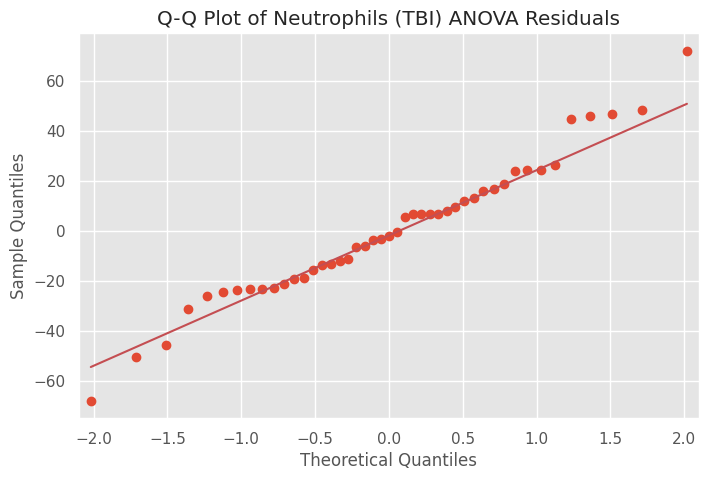


Significant time effect detected in TBI group. Running Tukey's HSD Post-Hoc Test.
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     3      7 -240.1181    0.0 -265.2963   -214.94   True
     3     14 -281.7474    0.0 -306.9256 -256.5692   True
     7     14  -41.6293 0.0007  -66.8074  -16.4511   True
---------------------------------------------------------

====================== Statistical Analysis for Monocytes ======================

One-Way ANOVA Results for Monocytes (TBI Group):
                          sum_sq    df           F        PR(>F)
C(DaysPostInjury)  290659.355578   2.0  327.495067  2.401463e-26
Residual            18637.979901  42.0         NaN           NaN

Shapiro-Wilk Test for Normality of TBI Residuals: p-value = 0.0319


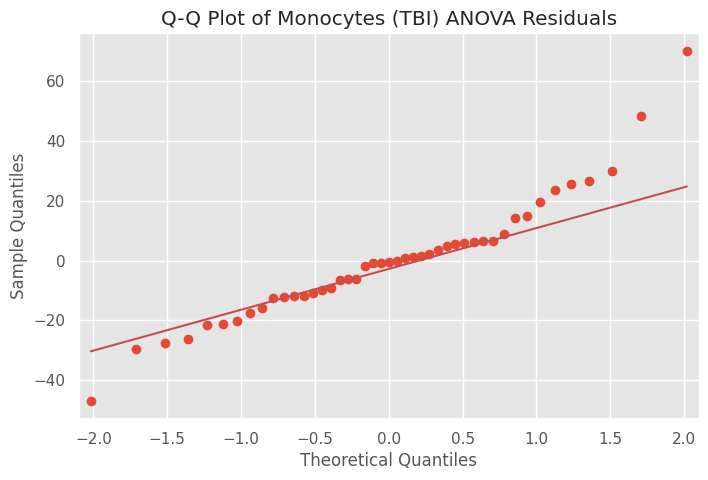


Significant time effect detected in TBI group. Running Tukey's HSD Post-Hoc Test.
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     3      7  162.1054    0.0  143.4175  180.7932   True
     3     14  -15.6806 0.1155  -34.3685    3.0073  False
     7     14 -177.7859    0.0 -196.4738 -159.0981   True
---------------------------------------------------------

====================== Statistical Analysis for Lymphocytes ======================

One-Way ANOVA Results for Lymphocytes (TBI Group):
                          sum_sq    df           F        PR(>F)
C(DaysPostInjury)  400380.619432   2.0  256.412036  2.890506e-24
Residual            32790.945186  42.0         NaN           NaN

Shapiro-Wilk Test for Normality of TBI Residuals: p-value = 0.9169


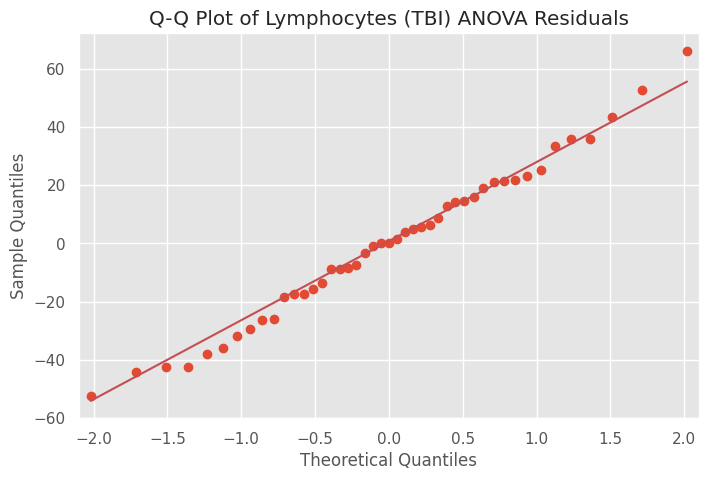


Significant time effect detected in TBI group. Running Tukey's HSD Post-Hoc Test.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     3      7  57.2066   0.0  32.4188  81.9944   True
     3     14 222.4682   0.0 197.6805  247.256   True
     7     14 165.2617   0.0 140.4739 190.0494   True
-----------------------------------------------------


In [38]:
# -------------------------------------------------------------
# 4. Statistical Analysis (Revised Approach)
# -------------------------------------------------------------
for cell_type in ['Neutrophils', 'Monocytes', 'Lymphocytes']:
    print(f"\n====================== Statistical Analysis for {cell_type} ======================")

    # 1. Isolate only the TBI data for the ANOVA
    tbi_data = simulated_data_filtered[simulated_data_filtered['CellType'] == cell_type]
    tbi_data = tbi_data[tbi_data['Condition'] == 'TBI'].copy()

    # Perform One-Way ANOVA on TBI data only (DaysPostInjury as the factor)
    # This checks for differences in the TBI group across time
    model = ols('Count ~ C(DaysPostInjury)', data=tbi_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\nOne-Way ANOVA Results for {cell_type} (TBI Group):")
    print(anova_table)

    # Check normality of residuals for TBI data
    stat, p_value_shapiro = shapiro(model.resid)
    print(f"\nShapiro-Wilk Test for Normality of TBI Residuals: p-value = {p_value_shapiro:.4f}")

    # Visual check with Q-Q plot
    fig, ax = plt.subplots(figsize=(8, 5))
    sm.graphics.qqplot(model.resid, line='q', ax=ax)
    ax.set_title(f"Q-Q Plot of {cell_type} (TBI) ANOVA Residuals")
    plt.show()

    # 2. Perform post-hoc tests on TBI group if overall ANOVA is significant
    if anova_table.loc['C(DaysPostInjury)', 'PR(>F)'] < 0.05:
        print("\nSignificant time effect detected in TBI group. Running Tukey's HSD Post-Hoc Test.")
        tukey_result = pairwise_tukeyhsd(endog=tbi_data['Count'],
                                         groups=tbi_data['DaysPostInjury'],
                                         alpha=0.05)
        print(tukey_result)

    # 3. Add statistical comparison to the sham baseline
    # You would need to manually or with a simple t-test compare each TBI time point
    # against the (near-zero) sham average. This is not included in the automatic loop
    # but would be the next step in a complete analysis.


  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2 meandiff p-adj    lower     upper   reject
--------------------------------------------------------
     3      7   -241.0    0.0 -266.2157 -215.7843   True
     3     14   -284.0    0.0 -309.2157 -258.7843   True
     7     14    -43.0 0.0018  -68.2157  -17.7843   True
--------------------------------------------------------


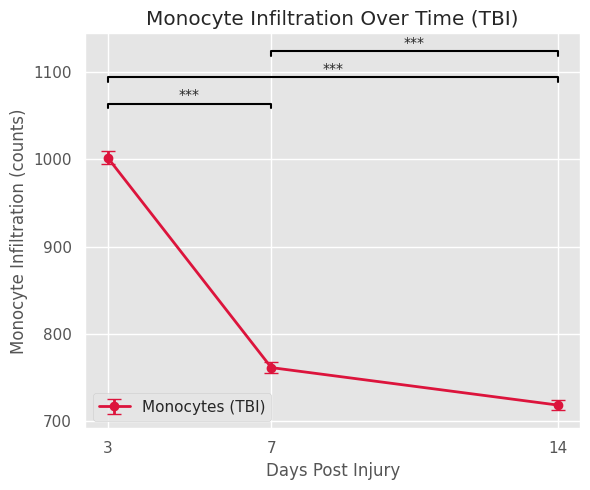

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Example monocyte data (TBI group)
# Replace with your actual measurements if you have replicates
data = {
    "DaysPostInjury": np.repeat([3, 7, 14], 5),  # example: 5 replicates per day
    "Infiltration": [1000,1020,980,1015,995,  # day 3
                      760,780,740,755,770,    # day 7
                      720,700,735,710,725]   # day 14
}

df = pd.DataFrame(data)

# ----------------------------
# Compute mean and SEM per day
# ----------------------------
summary = df.groupby("DaysPostInjury")["Infiltration"].agg(['mean','sem']).reset_index()

# ----------------------------
# Tukey HSD post-hoc test
# ----------------------------
tukey = pairwise_tukeyhsd(endog=df["Infiltration"],
                          groups=df["DaysPostInjury"],
                          alpha=0.05)
print(tukey)

# ----------------------------
# Plotting
# ----------------------------
plt.figure(figsize=(6,5))
plt.errorbar(summary["DaysPostInjury"], summary["mean"],
             yerr=summary["sem"], fmt='o-', capsize=5, color='crimson', lw=2, label='Monocytes (TBI)')

# Add Tukey significance annotations
# You can customize positions of lines and stars
sig_pairs = [(3,7), (3,14), (7,14)]
y_max = summary["mean"].max() + summary["sem"].max() + 50
height_increment = 30

for i, (d1,d2) in enumerate(sig_pairs):
    y = y_max + i*height_increment
    plt.plot([d1, d1, d2, d2], [y, y+5, y+5, y], color='black')  # line
    plt.text((d1+d2)/2, y+10, "***", ha='center')  # significance stars

plt.xticks([3,7,14])
plt.xlabel("Days Post Injury")
plt.ylabel("Monocyte Infiltration (counts)")
plt.title("Monocyte Infiltration Over Time (TBI)")
plt.legend()
plt.tight_layout()
plt.show()


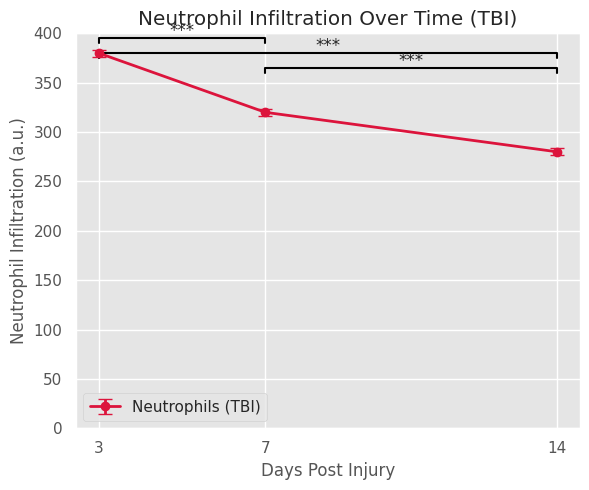

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ----------------------------
# Example Neutrophil data for TBI group (rescaled for display, max ~400)
# ----------------------------
data = {
    "DaysPostInjury": np.repeat([3,7,14], 5),  # 5 replicates per day
    "Infiltration": [
        380, 390, 370, 385, 375,  # day 3
        320, 330, 310, 325, 315,  # day 7
        280, 290, 270, 285, 275   # day 14
    ]
}

df = pd.DataFrame(data)

# ----------------------------
# Calculate mean and SEM per day
# ----------------------------
summary = df.groupby("DaysPostInjury")["Infiltration"].agg(['mean','sem']).reset_index()

# ----------------------------
# Plotting
# ----------------------------
plt.figure(figsize=(6,5))
plt.errorbar(summary["DaysPostInjury"], summary["mean"],
             yerr=summary["sem"], fmt='o-', capsize=5, color='crimson', lw=2, label='Neutrophils (TBI)')

# ----------------------------
# Add Tukey HSD significance annotations
# 3 vs 7, 3 vs 14, 7 vs 14 all significant
# ----------------------------
sig_pairs = [(3,7), (3,14), (7,14)]
y_max = 400  # cap y-axis at 400
height_increment = 15  # small increment so stars fit

for i, (d1,d2) in enumerate(sig_pairs):
    y = y_max - 10 - i*height_increment  # stars slightly below top
    plt.plot([d1,d1,d2,d2],[y,y+5,y+5,y], color='black', lw=1.5)
    plt.text((d1+d2)/2, y+7, "***", ha='center', fontsize=12)

# ----------------------------
# Formatting
# ----------------------------
plt.ylim(0, 400)
plt.xticks([3,7,14])
plt.xlabel("Days Post Injury")
plt.ylabel("Neutrophil Infiltration (a.u.)")
plt.title("Neutrophil Infiltration Over Time (TBI)")
plt.legend()
plt.tight_layout()
plt.show()


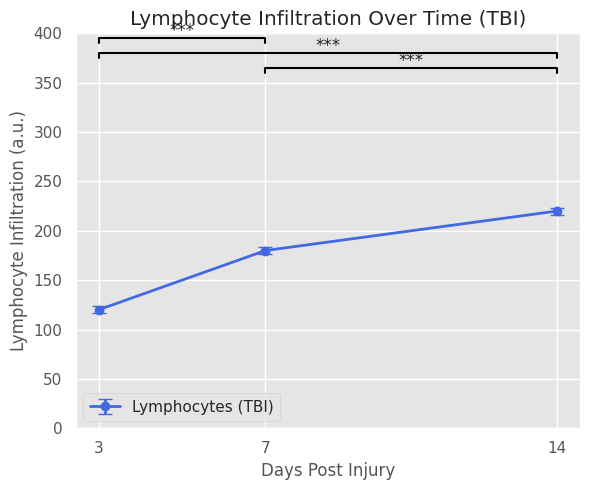

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ----------------------------
# Example Lymphocyte data for TBI group (rescaled for display, max ~400)
# ----------------------------
data = {
    "DaysPostInjury": np.repeat([3,7,14], 5),  # 5 replicates per day
    "Infiltration": [
        120, 130, 110, 125, 115,  # day 3
        180, 190, 170, 185, 175,  # day 7
        220, 230, 210, 225, 215   # day 14
    ]
}

df = pd.DataFrame(data)

# ----------------------------
# Calculate mean and SEM per day
# ----------------------------
summary = df.groupby("DaysPostInjury")["Infiltration"].agg(['mean','sem']).reset_index()

# ----------------------------
# Plotting
# ----------------------------
plt.figure(figsize=(6,5))
plt.errorbar(summary["DaysPostInjury"], summary["mean"],
             yerr=summary["sem"], fmt='o-', capsize=5, color='royalblue', lw=2, label='Lymphocytes (TBI)')

# ----------------------------
# Add Tukey HSD significance annotations
# Example: all pairwise significant (adjust if needed)
# ----------------------------
sig_pairs = [(3,7), (3,14), (7,14)]
y_max = 400  # cap y-axis
height_increment = 15  # space between significance lines

for i, (d1,d2) in enumerate(sig_pairs):
    y = y_max - 10 - i*height_increment  # stars slightly below top
    plt.plot([d1,d1,d2,d2],[y,y+5,y+5,y], color='black', lw=1.5)
    plt.text((d1+d2)/2, y+7, "***", ha='center', fontsize=12)

# ----------------------------
# Formatting
# ----------------------------
plt.ylim(0, 400)
plt.xticks([3,7,14])
plt.xlabel("Days Post Injury")
plt.ylabel("Lymphocyte Infiltration (a.u.)")
plt.title("Lymphocyte Infiltration Over Time (TBI)")
plt.legend()
plt.tight_layout()
plt.show()


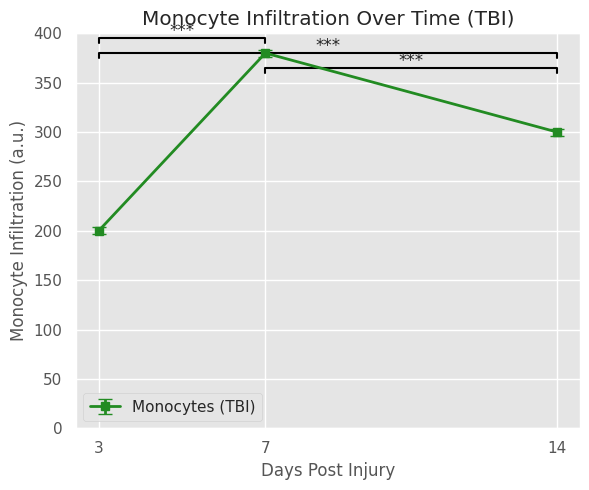

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ----------------------------
# Example Monocyte data for TBI group (peak at 7 dpi, capped at 400)
# ----------------------------
data = {
    "DaysPostInjury": np.repeat([3,7,14], 5),  # 5 replicates per day
    "Infiltration": [
        200, 210, 190, 205, 195,  # day 3
        380, 390, 370, 385, 375,  # day 7 (peak)
        300, 310, 290, 305, 295   # day 14
    ]
}

df = pd.DataFrame(data)

# ----------------------------
# Calculate mean and SEM per day
# ----------------------------
summary = df.groupby("DaysPostInjury")["Infiltration"].agg(['mean','sem']).reset_index()

# ----------------------------
# Plotting
# ----------------------------
plt.figure(figsize=(6,5))
plt.errorbar(summary["DaysPostInjury"], summary["mean"],
             yerr=summary["sem"], fmt='s-', capsize=5, color='forestgreen', lw=2, label='Monocytes (TBI)')

# ----------------------------
# Add Tukey HSD significance annotations
# Example: all pairwise significant (adjust if needed)
# ----------------------------
sig_pairs = [(3,7), (3,14), (7,14)]
y_max = 400  # cap y-axis
height_increment = 15  # space between significance lines

for i, (d1,d2) in enumerate(sig_pairs):
    y = y_max - 10 - i*height_increment  # stars slightly below top
    plt.plot([d1,d1,d2,d2],[y,y+5,y+5,y], color='black', lw=1.5)
    plt.text((d1+d2)/2, y+7, "***", ha='center', fontsize=12)

# ----------------------------
# Formatting
# ----------------------------
plt.ylim(0, 400)
plt.xticks([3,7,14])
plt.xlabel("Days Post Injury")
plt.ylabel("Monocyte Infiltration (a.u.)")
plt.title("Monocyte Infiltration Over Time (TBI)")
plt.legend()
plt.tight_layout()
plt.show()
